In [1]:
#standard package
import pandas as pd
import numpy as np
import os
import math
from collections import Counter
import time 
import glob
import tqdm
import sys
import shutil
import itertools
import pickle
import operator
from operator import itemgetter
import datetime as dt

#topics modeling
import pyLDAvis
import pyLDAvis.gensim
import gensim 
from gensim import corpora, models, similarities

#plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)
c:\users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
from UTILS import word_from_MLP
import config_mobility as config

c:\users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


we restrict the time series to one value per 60 seconds 
we compute the complexity variables each 30 minutes 
each variables includes the values of at least the last 120.00 minutes (i.e. are using 120.00 values)


In [3]:
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
title_ = '_LB' #'_LB', '_all','_LSL'

# Download data

In [4]:
df_master = pd.read_csv(os.path.join(path_initial_data,'Mo_Masterfile.csv'), sep=';',parse_dates=['day']) #, parse_dates=['date']) wrong!
df_master.rename(columns={'time':'Timestamp','day':'DayID','hen':'HenID','date':'day'}, inplace=True)
df_master['HenID'] = df_master['HenID'].map(lambda x: 'hen_'+str(x))
print(df_master.shape)
display(df_master.head(3))
#dico_henid_hybrid = dict(zip(df_master['HenID'].tolist(),df_master['hybrid'].tolist()))
li_LB = df_master[df_master['hybrid']=='LB']['HenID'].unique()
li_LSL = df_master[df_master['hybrid']=='LSL']['HenID'].unique()
print(len(li_LB), len(li_LSL))
li_LB[0:2]

(7920, 43)


,HenID,timepoint,group,age,DayID,day,file,severity,pen,hybrid,...,meanchange,mean1,medianchange,transitions,real0,sumdur,nest_vs_total,severity_diff,KBF_new,indicator
0,hen_1,1,A,21,1,27.10.2016,1A01,0.0,1,LSL,...,1.23,1.0,1.0,91.0,NaN,57067.0,0.177419,NaN,0.0,NaN
1,hen_1,1,A,21,2,28.10.2016,1A01,0.0,1,LSL,...,1.28,1.0,1.0,108.0,NaN,56854.0,0.171053,0.0,0.0,NaN
2,hen_1,1,A,21,3,29.10.2016,1A01,0.0,1,LSL,...,1.17,1.0,1.0,128.0,NaN,56721.0,0.255319,0.0,0.0,NaN


60 60


array(['hen_41', 'hen_42'], dtype=object)

In [5]:
#open time series per session and compute the variables for each session (car time series make sence at session level), et en 
#plus des variables tel que running entropy over the whole session ateach last timestamp of each level make sence only at 
#session level
START_TIME = time.clock()
starting_hour = 2
li_path = glob.glob(os.path.join(path_extracted_data, id_run+'_TimeSeries_*.csv'))
li_path = [i for i in li_path if '_hen_' not in i]
li_df = []
for path_ in tqdm.tqdm(li_path):
    
    #download time series associated to this session
    name_ = path_.split('_')[-1].split('.')[0]
    print('-------------------------------------------------------------------------', name_)
    df_ts = pd.read_csv(path_, sep=';', parse_dates=['Timestamp', 'day']) 
    li_hours_to_consider=list(range(starting_hour,17))
    df_ts['is_day'] = df_ts['hour'].map(lambda x: x in li_hours_to_consider)
    print(df_ts.shape)
    df_ts = df_ts[df_ts['is_day']]
    print(df_ts.shape)
    df_ts['session'] = name_
    li_df.append(df_ts)
df_ts = pd.concat(li_df)
print(df_ts.shape)
display(df_ts.head(2))
display(df_ts.tail(2))    
END_TIME = time.clock()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))  

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

------------------------------------------------------------------------- 10A
(513000, 54)
(324000, 54)


  5%|███▊                                                                               | 1/22 [00:05<01:46,  5.07s/it]

------------------------------------------------------------------------- 10B


c:\users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(513000, 54)
(324000, 54)


  9%|███████▌                                                                           | 2/22 [00:09<01:38,  4.93s/it]

------------------------------------------------------------------------- 11A
(513000, 46)
(324000, 46)


 14%|███████████▎                                                                       | 3/22 [00:13<01:28,  4.67s/it]

------------------------------------------------------------------------- 11B
(513000, 48)
(324000, 48)


 18%|███████████████                                                                    | 4/22 [00:18<01:23,  4.65s/it]

------------------------------------------------------------------------- 1A
(513000, 64)
(324000, 64)


 23%|██████████████████▊                                                                | 5/22 [00:25<01:31,  5.36s/it]

------------------------------------------------------------------------- 1B
(513000, 63)
(324000, 63)


 27%|██████████████████████▋                                                            | 6/22 [00:31<01:28,  5.53s/it]

------------------------------------------------------------------------- 2A
(513000, 60)
(324000, 60)


 32%|██████████████████████████▍                                                        | 7/22 [00:37<01:24,  5.66s/it]

------------------------------------------------------------------------- 2B
(513000, 65)
(324000, 65)


 36%|██████████████████████████████▏                                                    | 8/22 [00:42<01:17,  5.53s/it]

------------------------------------------------------------------------- 3A
(513000, 63)
(324000, 63)


 41%|█████████████████████████████████▉                                                 | 9/22 [00:47<01:11,  5.50s/it]

------------------------------------------------------------------------- 3B
(513000, 64)
(324000, 64)


 45%|█████████████████████████████████████▎                                            | 10/22 [00:55<01:11,  5.98s/it]

------------------------------------------------------------------------- 4A
(513000, 59)
(324000, 59)


 50%|█████████████████████████████████████████                                         | 11/22 [01:00<01:03,  5.77s/it]

------------------------------------------------------------------------- 4B
(513000, 64)
(324000, 64)


 55%|████████████████████████████████████████████▋                                     | 12/22 [01:06<01:00,  6.05s/it]

------------------------------------------------------------------------- 5A
(513000, 59)
(324000, 59)


 59%|████████████████████████████████████████████████▍                                 | 13/22 [01:12<00:54,  6.03s/it]

------------------------------------------------------------------------- 5B
(513000, 63)
(324000, 63)


 64%|████████████████████████████████████████████████████▏                             | 14/22 [01:18<00:46,  5.85s/it]

------------------------------------------------------------------------- 6A
(513000, 60)
(324000, 60)


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [01:23<00:39,  5.60s/it]

------------------------------------------------------------------------- 6B
(513000, 63)
(324000, 63)


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [01:28<00:33,  5.56s/it]

------------------------------------------------------------------------- 7A
(513000, 57)
(324000, 57)


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [01:34<00:27,  5.54s/it]

------------------------------------------------------------------------- 7B
(513000, 61)
(324000, 61)


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [01:40<00:22,  5.62s/it]

------------------------------------------------------------------------- 8A
(513000, 56)
(324000, 56)


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [01:45<00:17,  5.67s/it]

------------------------------------------------------------------------- 8B
(513000, 62)
(324000, 62)


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [01:52<00:12,  6.04s/it]

------------------------------------------------------------------------- 9A


c:\users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(513000, 55)
(324000, 55)


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [01:58<00:05,  5.78s/it]

------------------------------------------------------------------------- 9B
(513000, 55)
(324000, 55)


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:03<00:00,  5.77s/it]


(7128000, 126)


,Timestamp,day,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,...,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99,hour,is_day,nbr_nan,session
1800,2017-07-06 02:00:00,2017-07-06,zone_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,True,0,10A
1801,2017-07-06 02:00:01,2017-07-06,zone_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,True,0,10A


,Timestamp,day,hen_1,hen_10,hen_100,hen_101,hen_102,hen_103,hen_104,hen_105,...,hen_94,hen_95,hen_96,hen_97,hen_98,hen_99,hour,is_day,nbr_nan,session
487798,2017-06-14 16:59:58,2017-06-14,NaN,NaN,NaN,zone_5,NaN,zone_2,zone_2,zone_3,...,zone_3,zone_4,zone_5,zone_5,zone_4,zone_2,16,True,0,9B
487799,2017-06-14 16:59:59,2017-06-14,NaN,NaN,NaN,zone_5,NaN,zone_2,zone_2,zone_3,...,zone_3,zone_4,zone_5,zone_5,zone_4,zone_2,16,True,0,9B


Total running time: 2.63 mn


In [6]:
#keep columns of one species only if wanted
print(df_ts.shape)
if title_ =='_LB':
    df_ts = df_ts.filter([x for x in df_ts.columns if (not x.startswith('hen_')) | (x in li_LB)],axis=1)
if title_ =='_LSL':
    df_ts = df_ts.filter([x for x in df_ts.columns if (not x.startswith('hen_')) | (x in li_LSL)],axis=1)
print(df_ts.shape)

(7128000, 126)
(7128000, 66)


# Topics modelling (lda - latent dirichlet allocation)

### define parameters

In [7]:
#define the fixed number of bouts included in each word
length_words = 3 #TO TEST: 3 et 4
#define 3 size of duration length (small, medium, long) that will be associated to each movement additionally to the daily hour 
#dico_size = {'transition':range(1,60),
#            'zone':range(60,60*60*24)}
dico_size = {'small':range(1,60),
             'intermediate':range(60,15*60),
             'large':range(15*60,60*60*24)}
li_hen = [i for i in df_ts.columns if i.startswith('hen_')]

100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:53<00:00,  3.72it/s]


164855 1555


,frequence,word
129,3481,"[['zone_3', 'zone_2', 'zone_3'], ['intermediat..."
253,3365,"[['zone_2', 'zone_3', 'zone_2'], ['intermediat..."
16,2557,"[['zone_3', 'zone_2', 'zone_3'], ['intermediat..."


,frequence,word
1162,1,"[['zone_5', 'zone_4', 'zone_1'], ['large', 'in..."
1159,1,"[['zone_1', 'zone_3', 'zone_2'], ['small', 'la..."
1554,1,"[['zone_5', 'zone_2', 'zone_1'], ['large', 'sm..."


We have 3439 documents (i.e. daily hens time series). The first one has 87 words (once cleaned)
There is 658 words in your dictionary
3439 [(5, 2), (8, 1), (10, 1), (12, 4), (17, 3), (18, 1), (27, 2), (32, 1), (40, 1), (46, 2), (55, 1), (56, 1), (57, 1), (58, 1), (65, 1), (67, 1), (76, 1), (114, 1), (117, 1), (118, 1), (119, 2), (120, 1), (143, 1), (146, 1), (148, 1), (154, 1), (159, 1), (162, 1), (163, 1), (171, 1), (172, 1), (177, 1), (195, 3), (210, 1), (213, 1), (215, 2), (218, 1), (243, 1), (254, 2), (272, 1), (279, 1), (293, 1), (307, 2), (308, 1), (309, 3), (310, 1), (311, 1), (312, 1), (313, 1)]


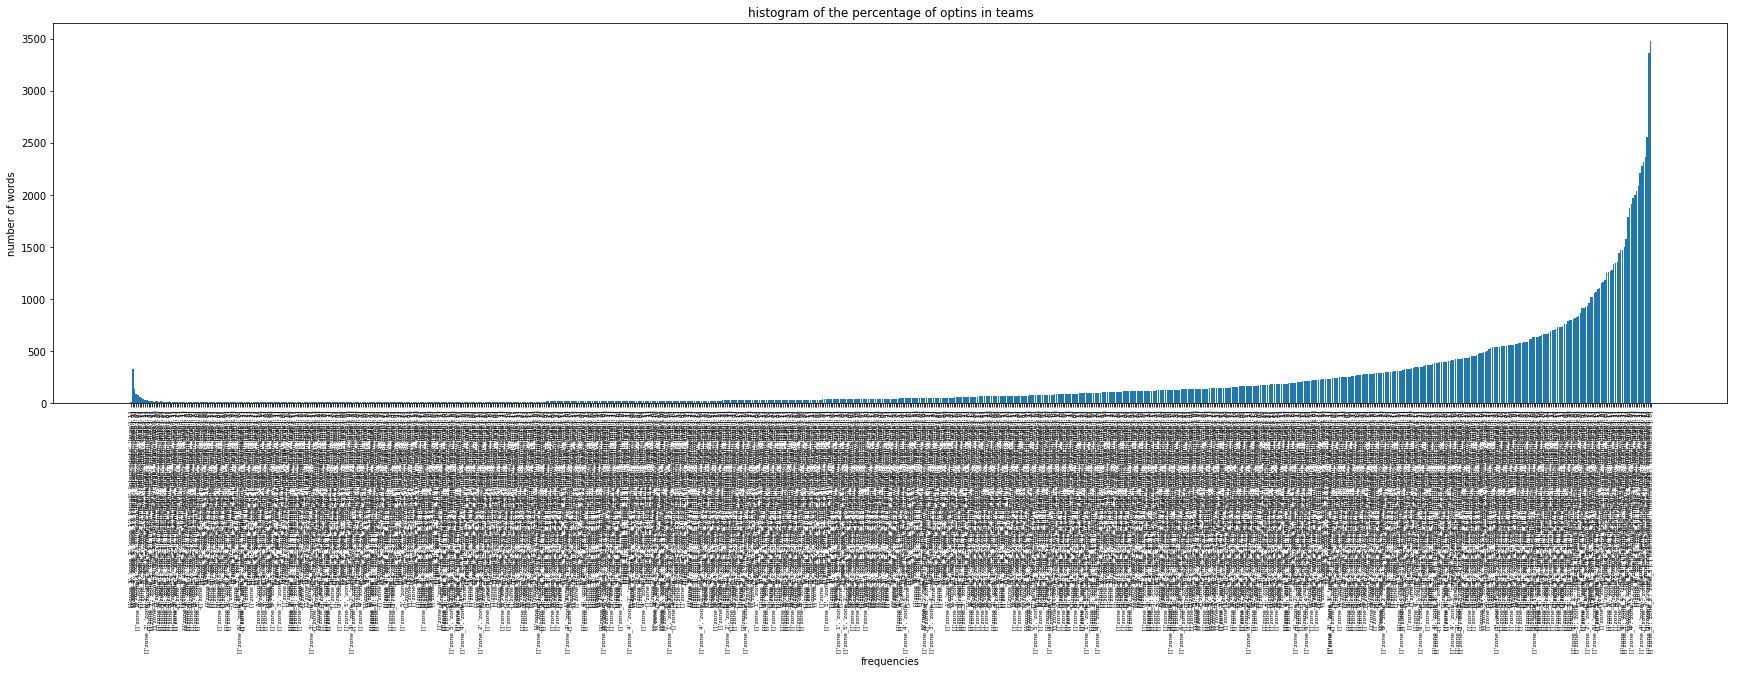

In [8]:
all_ = False

#create a director if not existing
path_save = os.path.join(path_extracted_data,'visual','LDA', title_)
if not os.path.exists(path_save):
    os.makedirs(path_save)
        
        
### documents:  set of words of daily hen time series
documents = {}
for day, df_ in tqdm.tqdm(df_ts.groupby(['day'])):
    df_ = df_.fillna(' ')
    for h in li_hen:
        li = df_[h].tolist()
        #remove if nan in ts or if only one zone (we separate for efficiency)
        if li[0]!=' ':
            if len(set(li))>1:
                documents[h+'/-/'+str(day).split(' ')[0]] = word_from_MLP(li, length_words, starting_hour, dico_size)

### frequence analysis
#create a list of all words
li_words = []
for h_day, li_li_tupleWordTime in documents.items():
    #tranform to string to make a dictionary
    li_words.extend([x for x in li_li_tupleWordTime])
print(len(li_words), len(set(li_words)))

#compute frequencies
c_words = Counter(li_words)
df_word_frequence = pd.DataFrame.from_dict({'word':list(c_words.keys()),'frequence':list(c_words.values())})
df_word_frequence = df_word_frequence.sort_values('frequence',ascending=False)
df_word_frequence.to_csv(os.path.join(path_save,'word_Frequence.csv'),index=False,sep=';')
display(df_word_frequence.head(3))
display(df_word_frequence.tail(3))

#simple barplot (sorted with x values)
d = {k:v for k,v in c_words.items() if v>5}
d = sorted(d.items(), key=operator.itemgetter(1))
x = [i[0] for i in d]
y = [i[1] for i in d]
fig = plt.figure(figsize=(30,7))
ax = plt.subplot(111)
width = 0.8
ax.bar(range(len(x)), y, width=width)
plt.title('most frequent words')
ax.set_xticks(np.arange(len(x)) + width/2)
ax.set_xticklabels(x, rotation=90,size=6);
plt.savefig(os.path.join(path_save,'most_frequent_word_'+str(length_words)+'.png'),dpi=300,format='png',bbox_inches='tight')

#histogram
plt.hist(df_word_frequence[df_word_frequence['frequence']<=100]['frequence'],bins=100) #into 15 equal parts 
#return: [0]: vector of length bins with #elements in each bins
#and [1]: when the vectors starts (for plot)
plt.title('histogram of the percentage of optins in teams')
plt.xlabel('frequencies')
plt.ylabel('number of words')    
#--> choose the nbr_times parameter: number of times a words need to appear at least this amount of time, in the overall set of 
#documents to be taken into account
nbr_times = 13

### clean documents
def MLPsWord4lda(documents, c_words, nbr_times):
    #remove all words appearing less or equal to nbr_times times in the overall time series
    tokens_removed = set(word for word in c_words.keys() if c_words[word]<nbr_times)
    cleaned_documents = {h_day:[word for word in words if word not in tokens_removed] for h_day,words in documents.items()}
    #perhaps later: remove with to much transition words? keep it for now, I dont know what this means
    return(cleaned_documents, tokens_removed)

cleaned_documents, tokens_removed = MLPsWord4lda(documents, c_words, nbr_times)
len(tokens_removed)

### dictionary & bag of word corpus
#dictionary:  mapping from word IDs to words
#keep track of the order of the li_documents regarding the ts ID
dico_tsID_listID = dict(zip(list(cleaned_documents.keys()),range(len(cleaned_documents.keys()))))
dico_listID_tsID = {v:k for k,v in dico_tsID_listID.items()}
li_documents = [cleaned_documents[dico_listID_tsID[listID]] for listID in range(len(dico_listID_tsID))]
print('We have %d documents (i.e. daily hens time series). The first one has %d words (once cleaned)'%(len(li_documents), 
                                                                                                       len(li_documents[0])))
dictionary = corpora.Dictionary(li_documents)
print('There is %d words in your dictionary'%len(dictionary))

#corpus: list with a bag of words (sparse document vectors: list of tuples(word_id, appearance)) for each documents
corpus = [dictionary.doc2bow(text) for text in li_documents]
print(len(corpus),corpus[10])

#save
pickle.dump(corpus, open(os.path.join(path_save,'corpus.pkl'), 'wb'))
dictionary.save(os.path.join(path_save,'dictionary.gensim'))

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

Total running time: 0min

---- 0
0.028*"[['zone_5', 'zone_4', 'zone_5'], ['small', 'small', 'small'], 1]" + 0.027*"[['zone_4', 'zone_5', 'zone_4'], ['small', 'small', 'small'], 1]" + 0.024*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 1]" + 0.024*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'large'], 1]" + 0.022*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 1]" + 0.022*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'large', 'large'], 1]" + 0.022*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 0]" + 0.021*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 0]" + 0.021*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'intermediate'], 1]" + 0.019*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'large'], 1]"

---- 1
0.047*"[['zone_3', 'zone_2', 'zone_3'], ['intermediate', 'intermediate', 'intermediate'], 0]" + 0.045*"[['zone_2'

topic,0,1
HenID,,
hen_1,45.0,19.0
hen_10,0.0,12.0
hen_11,48.0,7.0


topic,0,1
HenID,,
hen_10,0.000000,100.000000
hen_34,12.280702,87.719298
hen_33,38.888889,61.111111


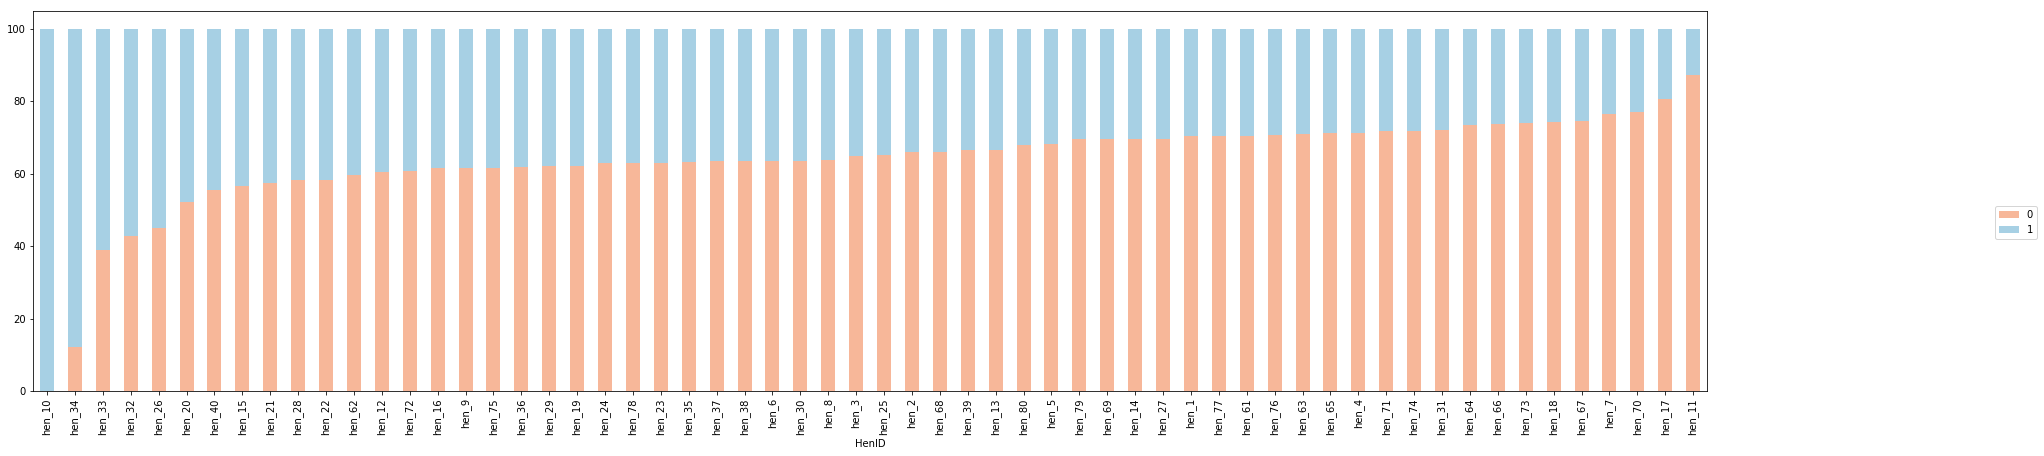

105
88


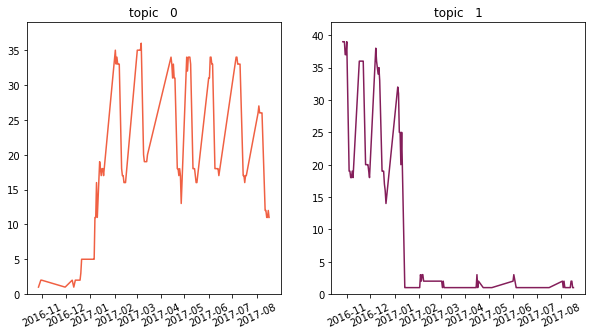

,day,documentID
0,2016-10-27,39
1,2016-10-28,39
2,2016-10-29,39


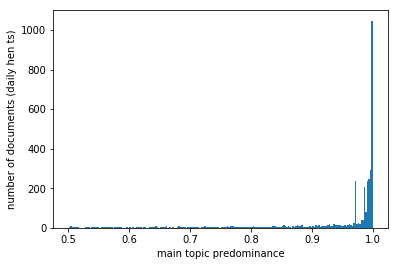


 29%|██████████████████████▉                                                       | 1011/3439 [00:18<00:58, 41.86it/s]


 86%|██████████████████████████████████████████████████████████████████▎          | 2962/3439 [00:37<00:02, 168.65it/s]


  8%|██████▍                                                                            | 1/13 [01:19<15:52, 79.35s/it]

Total running time: 0min

---- 0
0.033*"[['zone_5', 'zone_4', 'zone_5'], ['small', 'small', 'small'], 1]" + 0.031*"[['zone_4', 'zone_5', 'zone_4'], ['small', 'small', 'small'], 1]" + 0.028*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'large'], 1]" + 0.026*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 1]" + 0.026*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'large', 'large'], 1]" + 0.025*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 0]" + 0.025*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 1]" + 0.025*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 0]" + 0.023*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'intermediate'], 1]" + 0.022*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'large'], 1]"

---- 1
0.049*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 1]" + 0.041*"[['zone_4', 'zone_3', 'zone_4']

topic,0,1,2
HenID,,,
hen_1,41.0,11.0,12.0
hen_10,0.0,6.0,6.0
hen_11,48.0,0.0,7.0


topic,0,1,2
HenID,,,
hen_10,0.000000,50.000000,50.000000
hen_26,3.333333,60.000000,36.666667
hen_34,3.508772,52.631579,43.859649


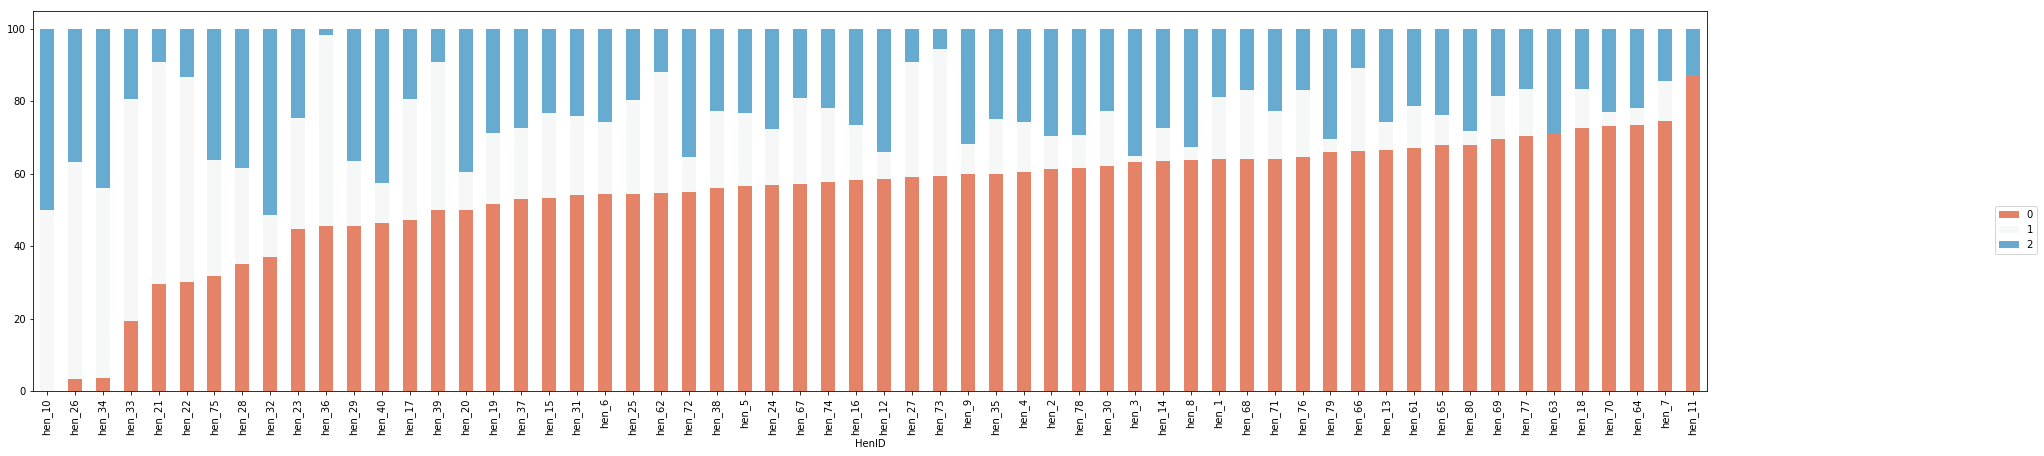

103
120
45


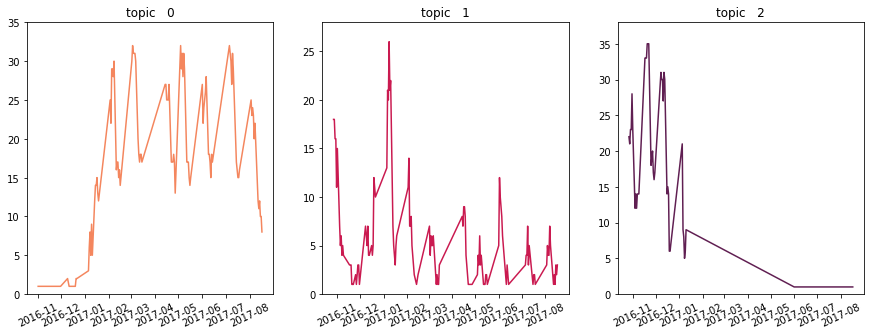

,day,documentID
0,2016-10-27,22
1,2016-10-28,21
2,2016-10-29,23


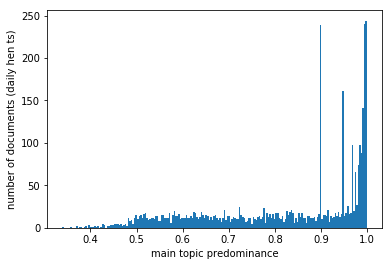


 15%|████████████▊                                                                      | 2/13 [01:59<12:22, 67.46s/it]

Total running time: 0min

---- 0
0.036*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'large'], 1]" + 0.036*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 1]" + 0.033*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'large', 'large'], 1]" + 0.032*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 0]" + 0.031*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'intermediate'], 1]" + 0.029*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 1]" + 0.027*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'large'], 1]" + 0.025*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'large'], 1]" + 0.023*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'intermediate'], 1]" + 0.022*"[['zone_5', 'zone_4', 'zone_5'], ['intermediate', 'large', 'large'], 1]"

---- 1
0.018*"[['zone_2', 'zone_3', 'zone_4'], ['intermediate', 'small', 'small'], 0]" + 0.017*"[['zone_3', 'zone_4', 'z

topic,0,1,2,3
HenID,,,,
hen_1,38.0,8.0,12.0,6.0
hen_10,0.0,6.0,6.0,0.0
hen_11,38.0,1.0,7.0,9.0


topic,0,1,2,3
HenID,,,,
hen_10,0.000000,50.000000,50.000000,0.0
hen_26,10.000000,53.333333,36.666667,0.0
hen_34,10.526316,47.368421,42.105263,0.0


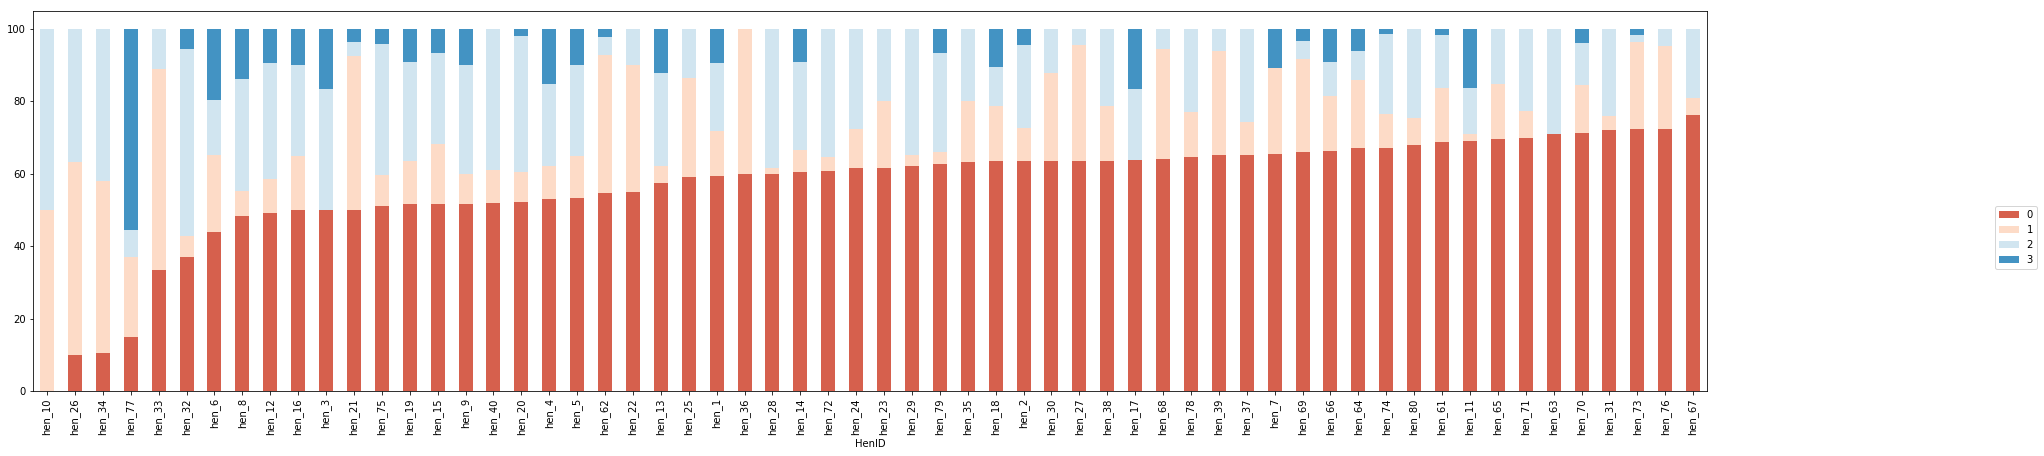

108
96
45
64


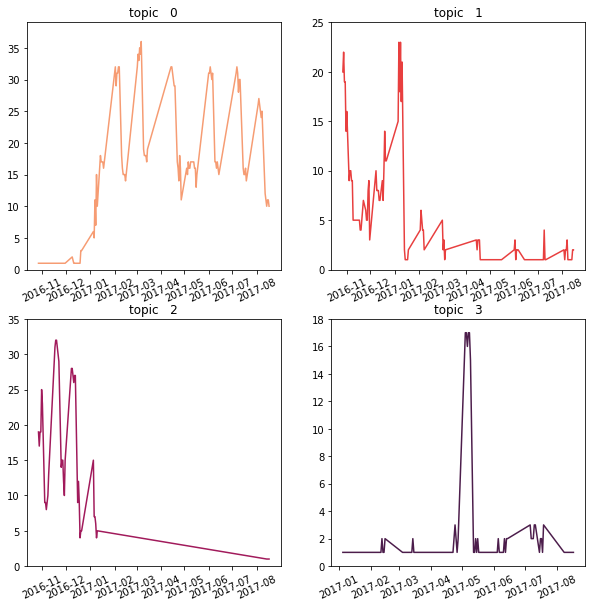

,day,documentID
0,2017-01-05,1
1,2017-01-06,1
2,2017-01-13,1


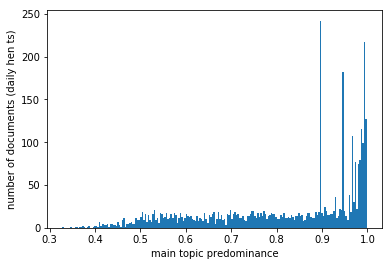


 23%|███████████████████▏                                                               | 3/13 [02:46<10:14, 61.43s/it]

Total running time: 0min

---- 0
0.035*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'large'], 1]" + 0.035*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 1]" + 0.033*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'large', 'large'], 1]" + 0.032*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 0]" + 0.031*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'intermediate'], 1]" + 0.030*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 1]" + 0.027*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'large'], 1]" + 0.025*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'large'], 1]" + 0.024*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 0]" + 0.023*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'intermediate'], 1]"

---- 1
0.020*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 0]" + 0.018*"[['zone_3', 'zone

topic,0,1,2,3,4
HenID,,,,,
hen_1,38.0,8.0,3.0,6.0,9.0
hen_10,0.0,6.0,4.0,0.0,2.0
hen_11,41.0,0.0,5.0,7.0,2.0


topic,0,1,2,3,4
HenID,,,,,
hen_10,0.00000,50.000000,33.333333,0.0,16.666667
hen_26,5.00000,58.333333,13.333333,0.0,23.333333
hen_34,8.77193,29.824561,45.614035,0.0,15.789474


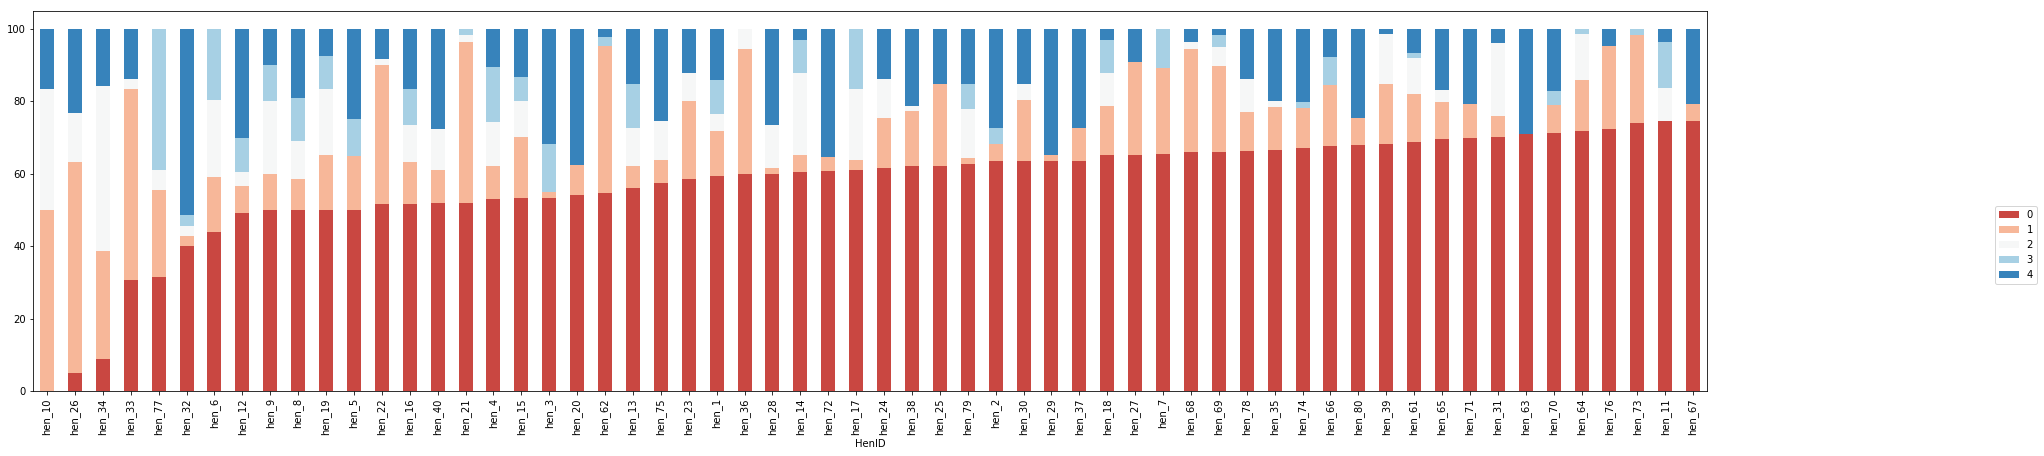

113
94
53
49
43


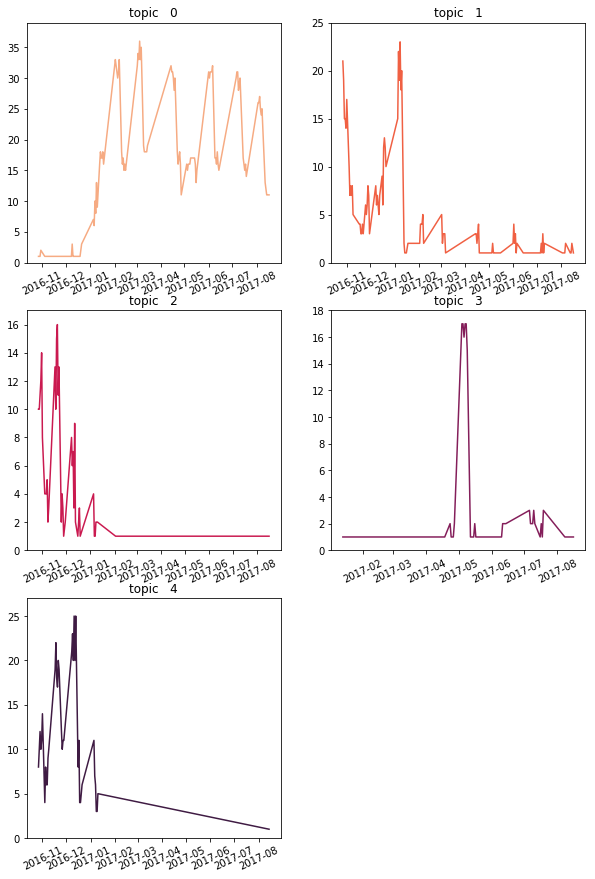

,day,documentID
0,2016-10-27,8
1,2016-10-28,10
2,2016-10-29,12


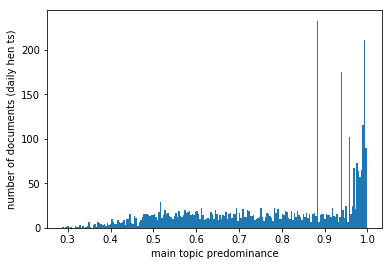


 31%|█████████████████████████▌                                                         | 4/13 [03:35<08:38, 57.63s/it]

Total running time: 0min

---- 0
0.062*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 1]" + 0.061*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'large'], 1]" + 0.057*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'large', 'large'], 1]" + 0.054*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'intermediate'], 1]" + 0.049*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 0]" + 0.043*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'large'], 1]" + 0.039*"[['zone_5', 'zone_4', 'zone_5'], ['intermediate', 'large', 'large'], 1]" + 0.037*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'intermediate'], 1]" + 0.036*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'large'], 0]" + 0.030*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'large'], 1]"

---- 1
0.164*"[['zone_5', 'zone_4', 'zone_5'], ['small', 'small', 'small'], 1]" + 0.153*"[['zone_4', 'zone_5', 'zone_4'], ['small', 's

topic,0,1,2,3,4,5
HenID,,,,,,
hen_1,34.0,5.0,6.0,5.0,14.0,0.0
hen_10,1.0,0.0,6.0,0.0,5.0,0.0
hen_11,35.0,4.0,5.0,9.0,2.0,0.0


topic,0,1,2,3,4,5
HenID,,,,,,
hen_77,0.000000,0.0,5.555556,70.37037,22.222222,1.851852
hen_34,7.017544,0.0,47.368421,0.00000,17.543860,28.070175
hen_10,8.333333,0.0,50.000000,0.00000,41.666667,0.000000


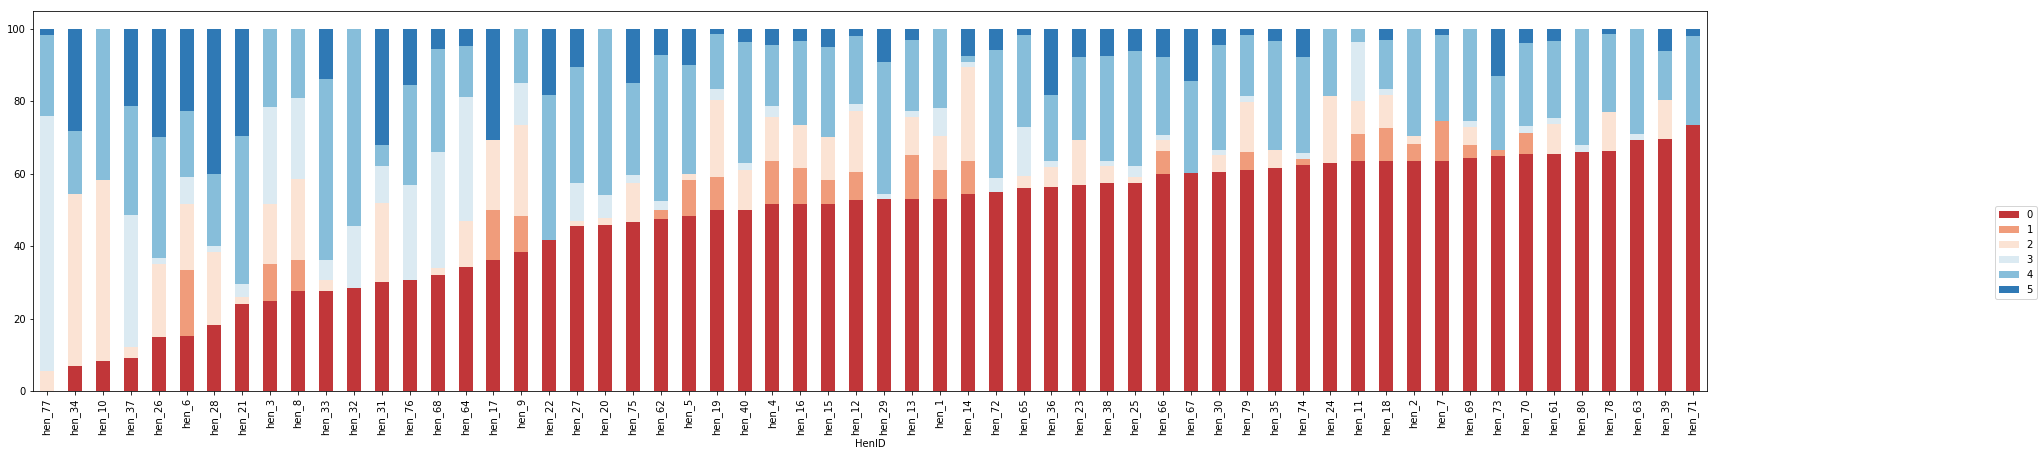

110
26
49
86
60
88


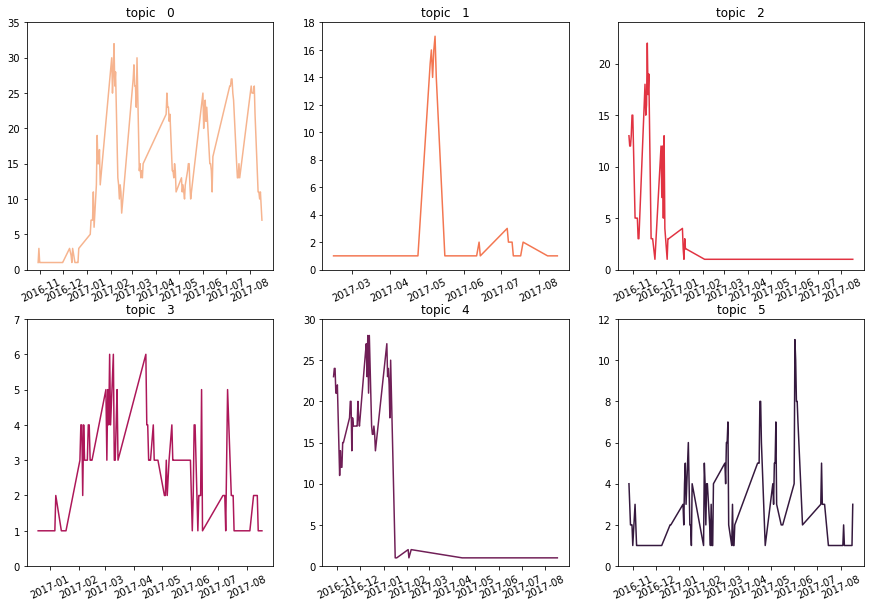

,day,documentID
0,2016-10-27,4
1,2016-10-28,3
2,2016-10-29,2


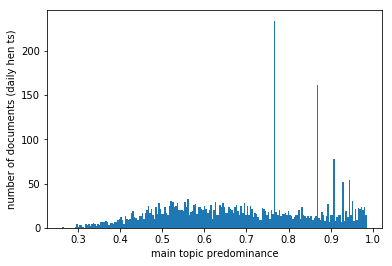


 38%|███████████████████████████████▉                                                   | 5/13 [04:27<07:27, 55.91s/it]

Total running time: 0min

---- 0
0.060*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 1]" + 0.052*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 1]" + 0.028*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 0]" + 0.028*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 0]" + 0.017*"[['zone_3', 'zone_4', 'zone_5'], ['small', 'small', 'large'], 0]" + 0.016*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'small', 'small'], 1]" + 0.015*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'intermediate', 'small'], 1]" + 0.015*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'intermediate'], 1]" + 0.015*"[['zone_2', 'zone_3', 'zone_4'], ['intermediate', 'small', 'intermediate'], 1]" + 0.013*"[['zone_3', 'zone_2', 'zone_3'], ['intermediate', 'intermediate', 'small'], 1]"

---- 1
0.147*"[['zone_5', 'zone_4', 'zone_5'], ['small', 'small', 'small'], 1]" + 0.137*"[['zone_4', 'zone_5', 'zone_4'], ['small', 'small', 'small'], 1]" + 0.074*"[['zo

topic,0,1,2,3,4,5,6
HenID,,,,,,,
hen_1,12.0,7.0,3.0,19.0,9.0,14.0,0.0
hen_10,2.0,0.0,3.0,0.0,2.0,1.0,4.0
hen_11,2.0,5.0,5.0,13.0,1.0,28.0,1.0


topic,0,1,2,3,4,5,6
HenID,,,,,,,
hen_79,0.000000,5.084746,10.169492,40.677966,18.644068,23.728814,1.694915
hen_63,1.612903,0.000000,0.000000,53.225806,17.741935,14.516129,12.903226
hen_3,1.666667,10.000000,0.000000,1.666667,33.333333,51.666667,1.666667


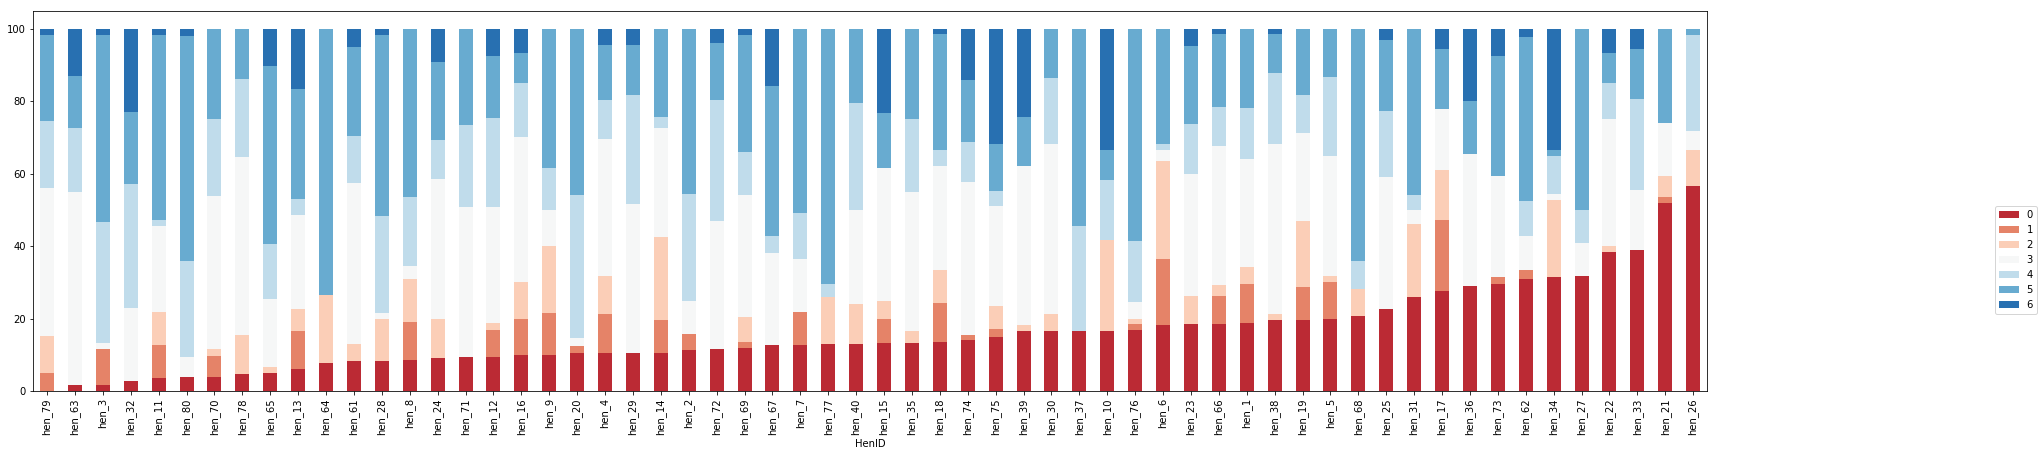

107
31
40
102
43
104
72


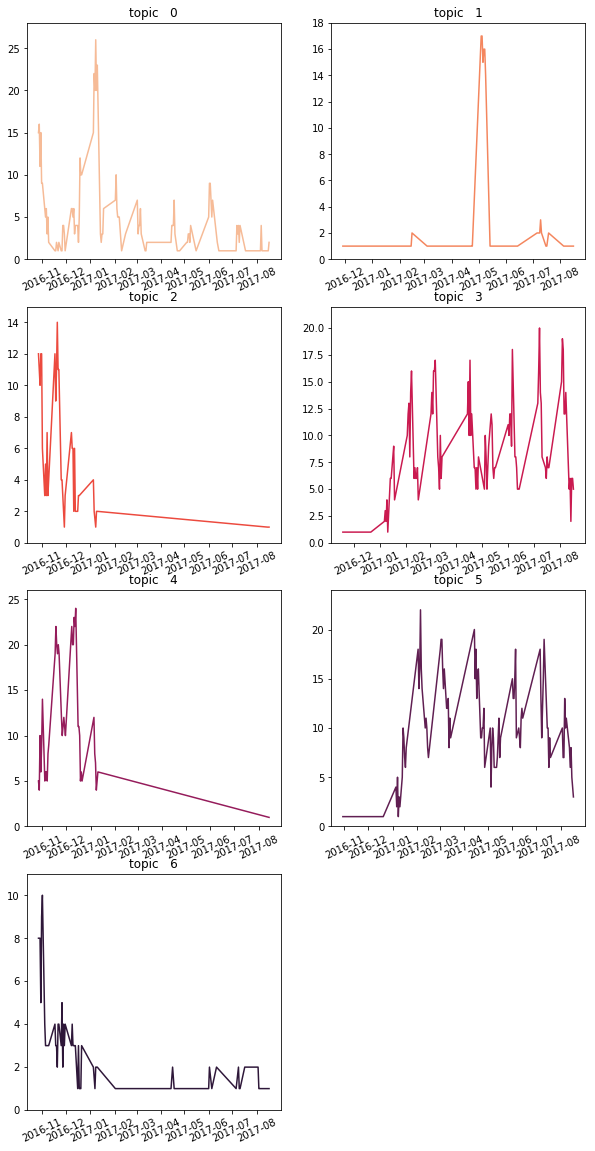

,day,documentID
0,2016-10-27,8
1,2016-10-28,8
2,2016-10-29,8


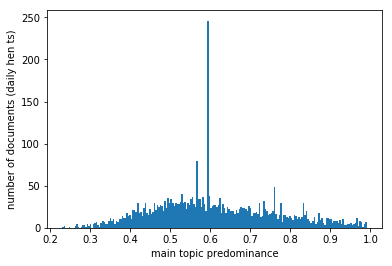


 46%|██████████████████████████████████████▎                                            | 6/13 [05:19<06:24, 54.98s/it]

Total running time: 0min

---- 0
0.069*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 1]" + 0.068*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'large'], 1]" + 0.064*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'large', 'large'], 1]" + 0.060*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'intermediate'], 1]" + 0.051*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 0]" + 0.046*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'large'], 1]" + 0.042*"[['zone_5', 'zone_4', 'zone_5'], ['intermediate', 'large', 'large'], 1]" + 0.041*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'intermediate'], 1]" + 0.040*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'large'], 0]" + 0.031*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'large'], 1]"

---- 1
0.109*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 1]" + 0.088*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 

topic,0,1,2,3,4,5,6,7
HenID,,,,,,,,
hen_1,30.0,1.0,4.0,2.0,2.0,7.0,10.0,8.0
hen_10,0.0,1.0,2.0,0.0,0.0,0.0,0.0,9.0
hen_11,33.0,0.0,5.0,0.0,2.0,11.0,2.0,2.0


topic,0,1,2,3,4,5,6,7
HenID,,,,,,,,
hen_10,0.000000,8.333333,16.666667,0.0,0.0,0.00000,0.00000,75.000000
hen_77,0.000000,1.851852,3.703704,0.0,0.0,70.37037,20.37037,3.703704
hen_34,3.508772,43.859649,21.052632,0.0,0.0,0.00000,0.00000,31.578947


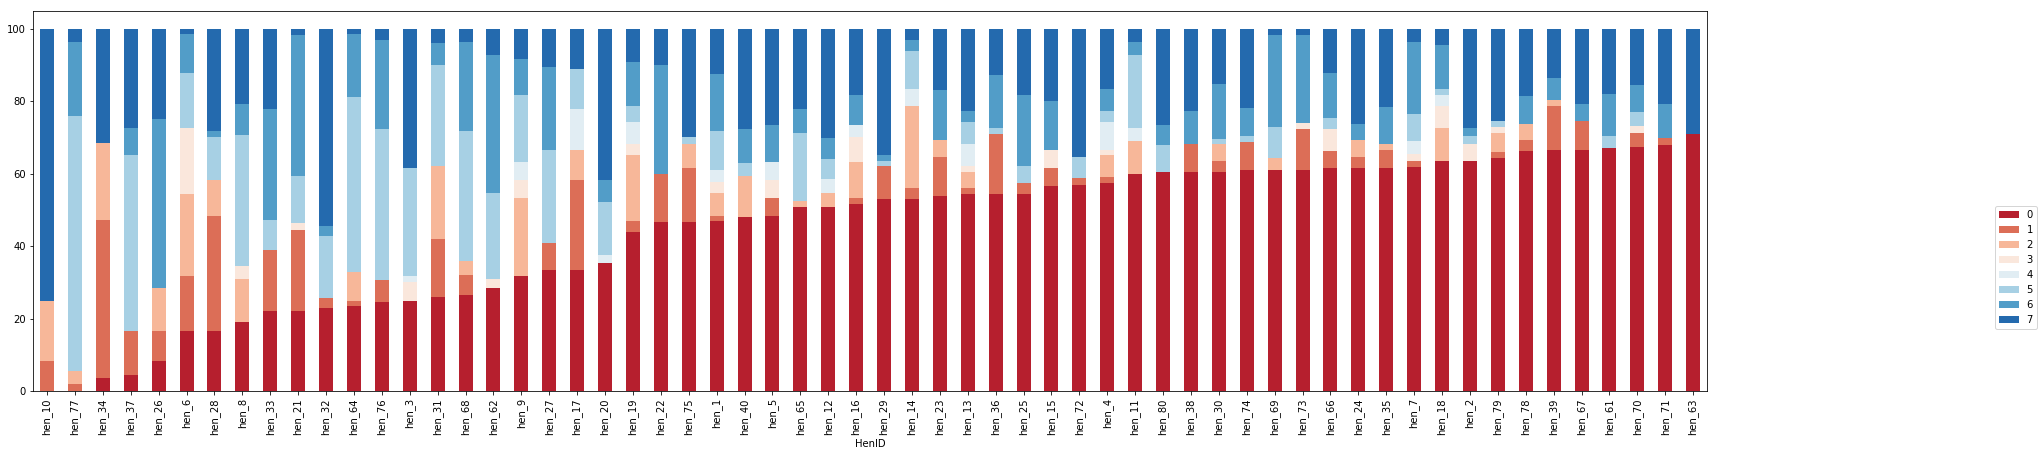

107
83
34
20
8
95
83
50


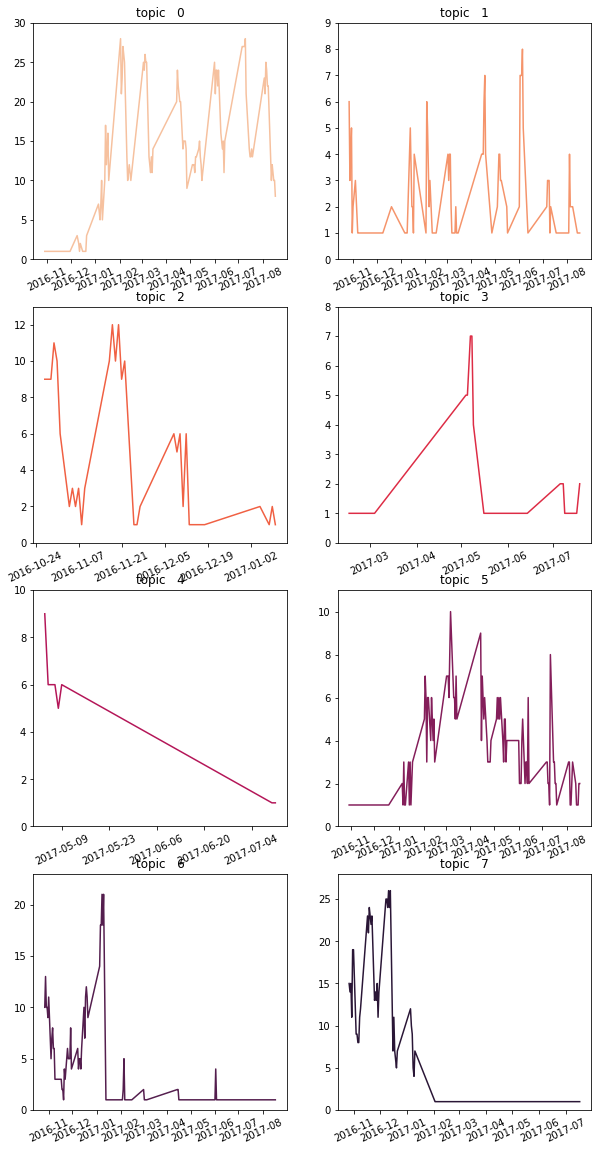

,day,documentID
0,2016-10-27,15
1,2016-10-28,14
2,2016-10-29,15


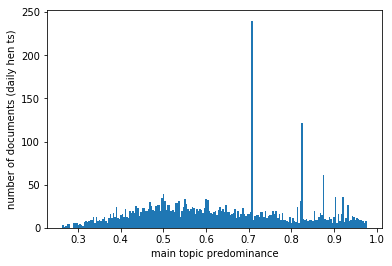


 54%|████████████████████████████████████████████▋                                      | 7/13 [06:14<05:29, 54.96s/it]

Total running time: 0min

---- 0
0.056*"[['zone_5', 'zone_4', 'zone_5'], ['intermediate', 'large', 'large'], 1]" + 0.050*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'large'], 1]" + 0.035*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'intermediate', 'large'], 1]" + 0.033*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 1]" + 0.029*"[['zone_5', 'zone_4', 'zone_5'], ['intermediate', 'intermediate', 'intermediate'], 1]" + 0.027*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 0]" + 0.025*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'intermediate'], 1]" + 0.023*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 0]" + 0.022*"[['zone_5', 'zone_4', 'zone_5'], ['intermediate', 'large', 'intermediate'], 1]" + 0.021*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'large', 'intermediate'], 1]"

---- 1
0.121*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 1]" + 0.097*"[['zone_4', 'zone_3', 'z

topic,0,1,2,3,4,5,6,7,8
HenID,,,,,,,,,
hen_1,7.0,2.0,4.0,3.0,1.0,9.0,7.0,8.0,23.0
hen_10,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,0.0
hen_11,4.0,0.0,5.0,1.0,2.0,12.0,4.0,2.0,25.0


topic,0,1,2,3,4,5,6,7,8
HenID,,,,,,,,,
hen_77,0.000000,1.851852,7.407407,0.000000,0.000000,70.370370,20.370370,0.000000,0.000000
hen_33,0.000000,25.000000,0.000000,0.000000,0.000000,5.555556,30.555556,22.222222,16.666667
hen_8,1.724138,0.000000,13.793103,6.896552,1.724138,36.206897,6.896552,18.965517,13.793103


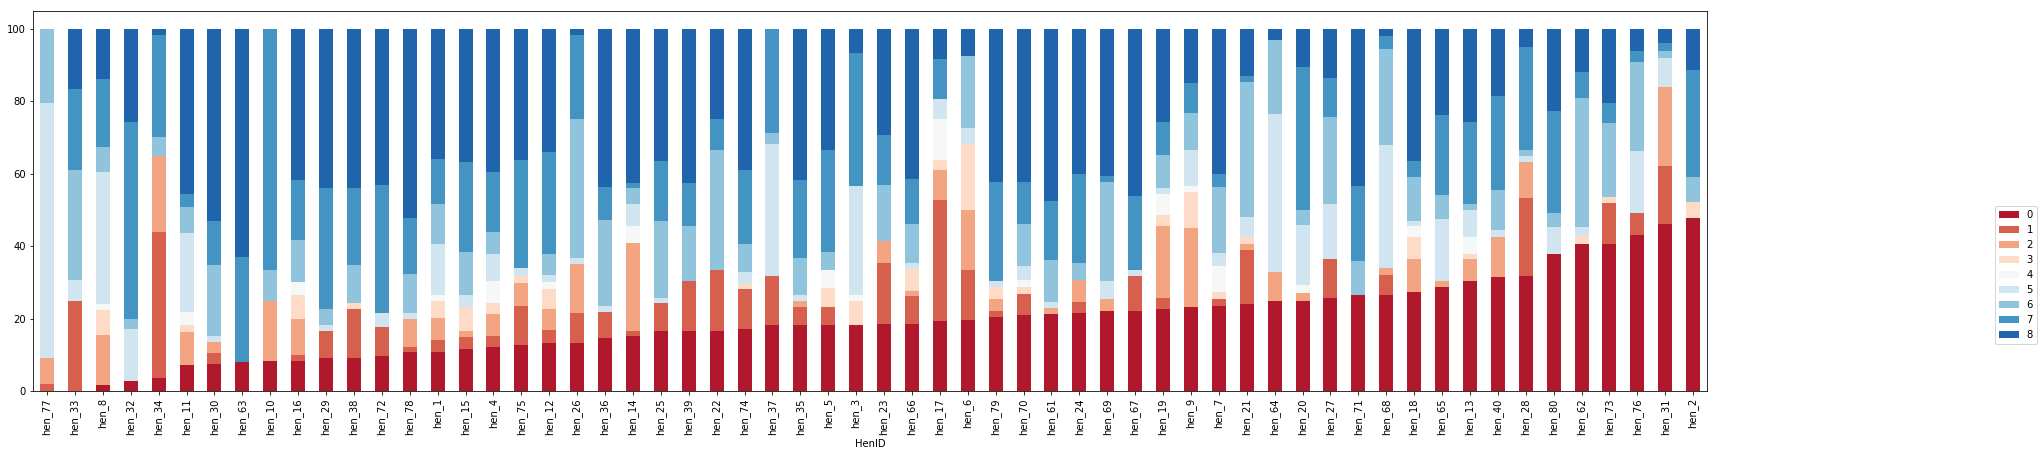

103
80
36
24
10
89
78
48
101


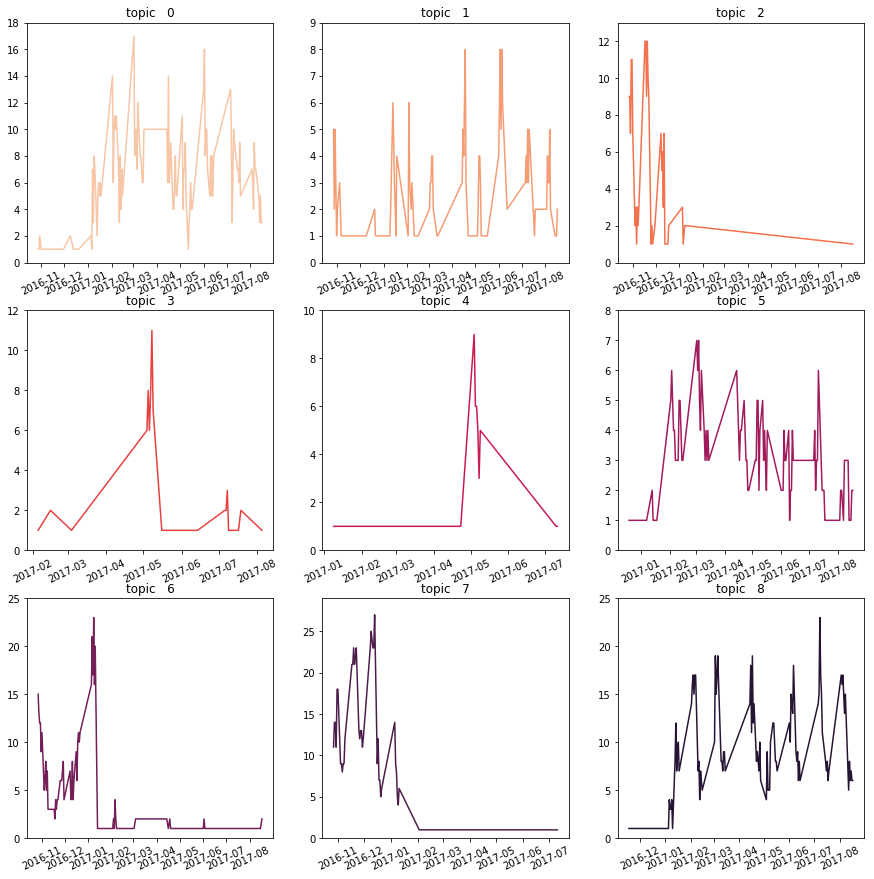

,day,documentID
0,2016-11-18,1
1,2016-12-09,1
2,2016-12-11,1


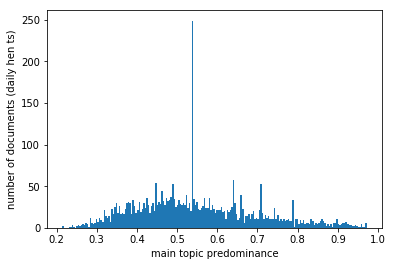


 62%|███████████████████████████████████████████████████                                | 8/13 [07:10<04:35, 55.14s/it]

Total running time: 0min

---- 0
0.067*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 0]" + 0.058*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 0]" + 0.044*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'small', 'small'], 0]" + 0.031*"[['zone_4', 'zone_5', 'zone_4'], ['small', 'large', 'intermediate'], 0]" + 0.029*"[['zone_5', 'zone_4', 'zone_3'], ['large', 'intermediate', 'small'], 0]" + 0.029*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'small', 'intermediate'], 0]" + 0.028*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'intermediate'], 0]" + 0.027*"[['zone_3', 'zone_4', 'zone_5'], ['small', 'intermediate', 'large'], 0]" + 0.024*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 0]" + 0.023*"[['zone_3', 'zone_4', 'zone_5'], ['small', 'small', 'large'], 0]"

---- 1
0.169*"[['zone_5', 'zone_4', 'zone_5'], ['small', 'small', 'small'], 1]" + 0.158*"[['zone_4', 'zone_5', 'zone_4'], ['small', 'small', 'small'

topic,0,1,2,3,4,5,6,7,8,9
HenID,,,,,,,,,,
hen_1,4.0,7.0,3.0,21.0,1.0,1.0,8.0,9.0,1.0,9.0
hen_10,0.0,0.0,4.0,0.0,1.0,0.0,5.0,2.0,0.0,0.0
hen_11,0.0,5.0,5.0,13.0,0.0,0.0,3.0,1.0,15.0,13.0


topic,0,1,2,3,4,5,6,7,8,9
HenID,,,,,,,,,,
hen_63,0.0,0.000000,0.0,50.000000,0.000000,1.612903,0.000000,29.032258,17.741935,1.612903
hen_3,0.0,6.666667,0.0,0.000000,0.000000,0.000000,0.000000,38.333333,21.666667,33.333333
hen_29,0.0,0.000000,0.0,36.363636,3.030303,12.121212,1.515152,34.848485,12.121212,0.000000


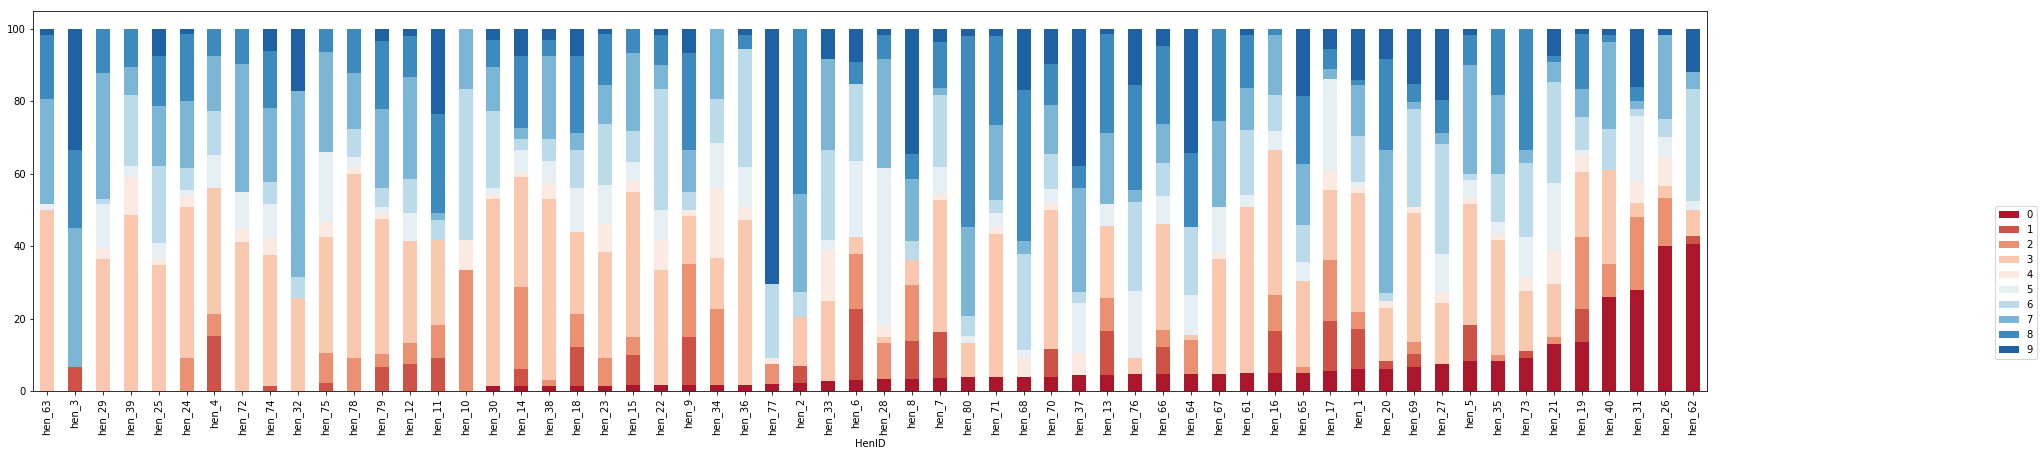

75
36
37
102
59
82
58
44
94
92


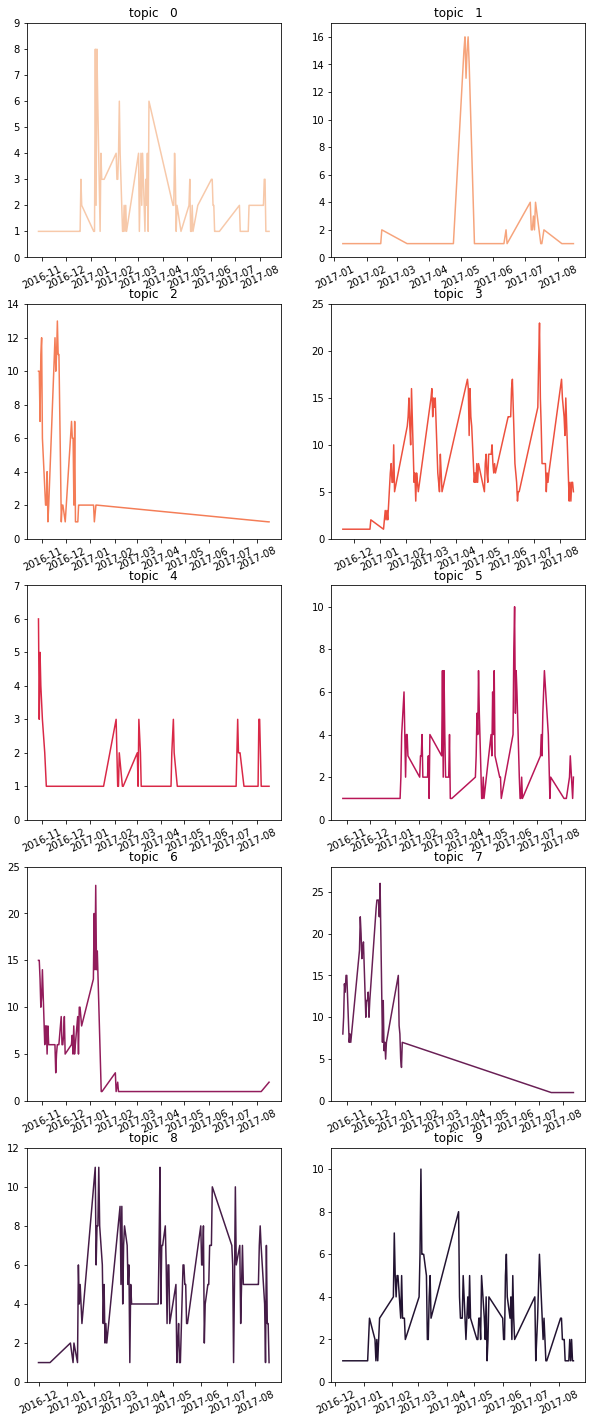

,day,documentID
0,2016-12-09,1
1,2016-12-19,1
2,2017-01-05,1


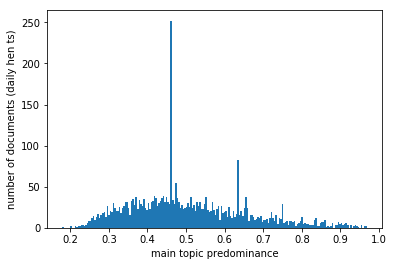


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [08:04<03:39, 54.92s/it]

Total running time: 0min

---- 0
0.080*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 0]" + 0.069*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 0]" + 0.050*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'small', 'small'], 0]" + 0.038*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'small', 'intermediate'], 0]" + 0.036*"[['zone_5', 'zone_4', 'zone_3'], ['large', 'intermediate', 'small'], 0]" + 0.034*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'intermediate'], 0]" + 0.032*"[['zone_3', 'zone_4', 'zone_5'], ['small', 'intermediate', 'large'], 0]" + 0.028*"[['zone_4', 'zone_5', 'zone_4'], ['small', 'large', 'intermediate'], 0]" + 0.026*"[['zone_3', 'zone_4', 'zone_5'], ['small', 'small', 'large'], 0]" + 0.024*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'intermediate', 'small'], 0]"

---- 1
0.131*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 1]" + 0.105*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 1]" + 0.050

topic,0,1,2,3,4,5,6,7,8,9,10
HenID,,,,,,,,,,,
hen_1,2.0,1.0,2.0,29.0,6.0,1.0,9.0,10.0,0.0,4.0,0.0
hen_10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,6.0
hen_11,0.0,0.0,5.0,31.0,6.0,1.0,2.0,2.0,0.0,8.0,0.0


topic,0,1,2,3,4,5,6,7,8,9,10
HenID,,,,,,,,,,,
hen_36,0.0,1.818182,0.000000,40.000000,0.000000,7.272727,10.909091,0.000000,3.636364,3.636364,32.727273
hen_79,0.0,0.000000,6.779661,42.372881,6.779661,16.949153,0.000000,23.728814,0.000000,0.000000,3.389831
hen_78,0.0,1.538462,7.692308,58.461538,0.000000,4.615385,12.307692,15.384615,0.000000,0.000000,0.000000


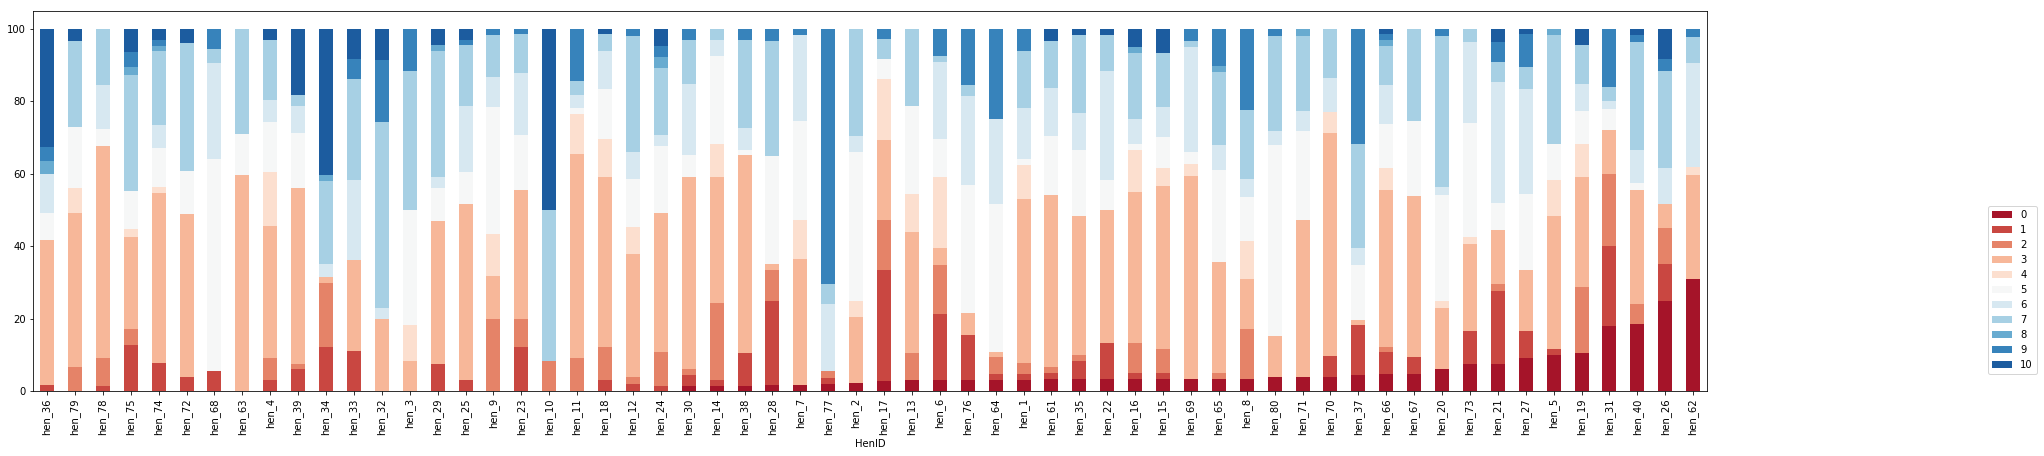

67
75
34
100
33
95
58
43
13
85
68


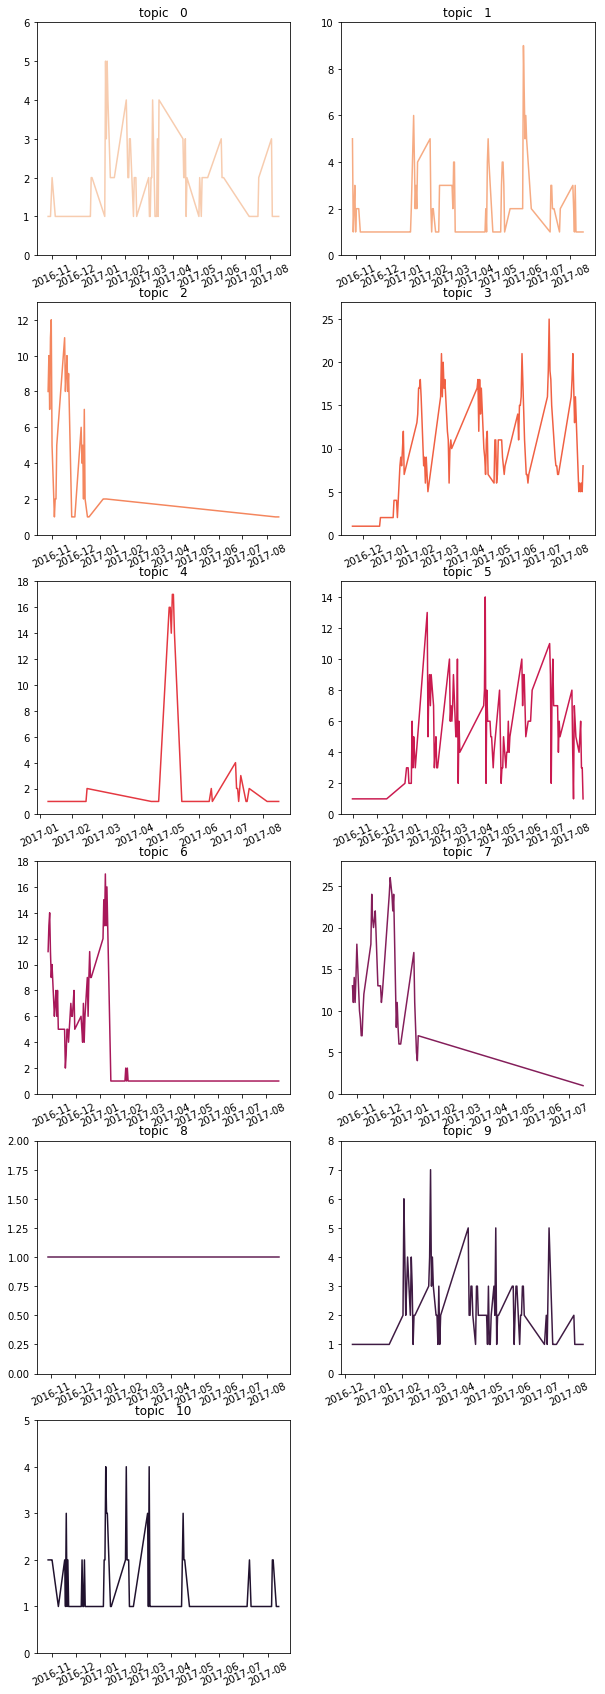

,day,documentID
0,2016-10-27,2
1,2016-10-28,2
2,2016-10-29,2


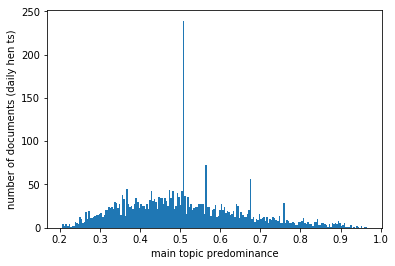


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [08:57<02:42, 54.15s/it]

Total running time: 0min

---- 0
0.082*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 0]" + 0.074*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 0]" + 0.048*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'small', 'small'], 0]" + 0.033*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'intermediate'], 0]" + 0.032*"[['zone_5', 'zone_4', 'zone_3'], ['large', 'intermediate', 'small'], 0]" + 0.030*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'small', 'intermediate'], 0]" + 0.030*"[['zone_3', 'zone_4', 'zone_5'], ['small', 'small', 'large'], 0]" + 0.029*"[['zone_4', 'zone_5', 'zone_4'], ['small', 'large', 'intermediate'], 0]" + 0.029*"[['zone_3', 'zone_4', 'zone_5'], ['small', 'intermediate', 'large'], 0]" + 0.026*"[['zone_5', 'zone_4', 'zone_3'], ['large', 'intermediate', 'intermediate'], 0]"

---- 1
0.032*"[['zone_4', 'zone_5', 'zone_4'], ['small', 'intermediate', 'small'], 0]" + 0.030*"[['zone_2', 'zone_3', 'zone_4'], ['intermediate', 'small', 

topic,0,1,2,3,4,5,6,7,8,9,10,11
HenID,,,,,,,,,,,,
hen_1,3.0,7.0,2.0,28.0,1.0,1.0,1.0,10.0,1.0,5.0,5.0,0.0
hen_10,0.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0
hen_11,0.0,3.0,5.0,30.0,0.0,0.0,1.0,1.0,1.0,7.0,6.0,1.0


topic,0,1,2,3,4,5,6,7,8,9,10,11
HenID,,,,,,,,,,,,
hen_75,0.0,0.000000,8.510638,4.255319,8.510638,17.021277,2.127660,6.382979,23.404255,8.510638,0.000000,21.276596
hen_4,0.0,9.090909,7.575758,21.212121,0.000000,7.575758,7.575758,12.121212,18.181818,9.090909,6.060606,1.515152
hen_39,0.0,10.606061,1.515152,25.757576,18.181818,3.030303,0.000000,3.030303,13.636364,6.060606,0.000000,18.181818


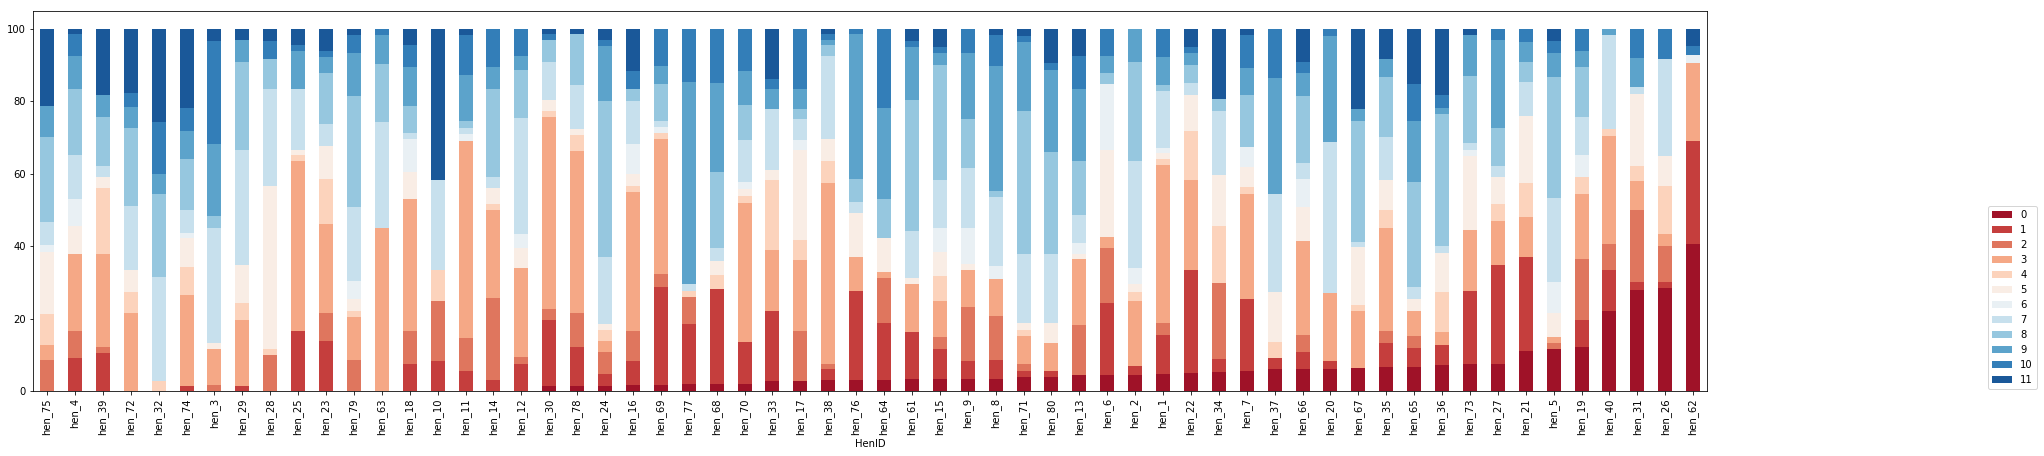

69
48
39
101
64
81
28
43
95
95
77
56


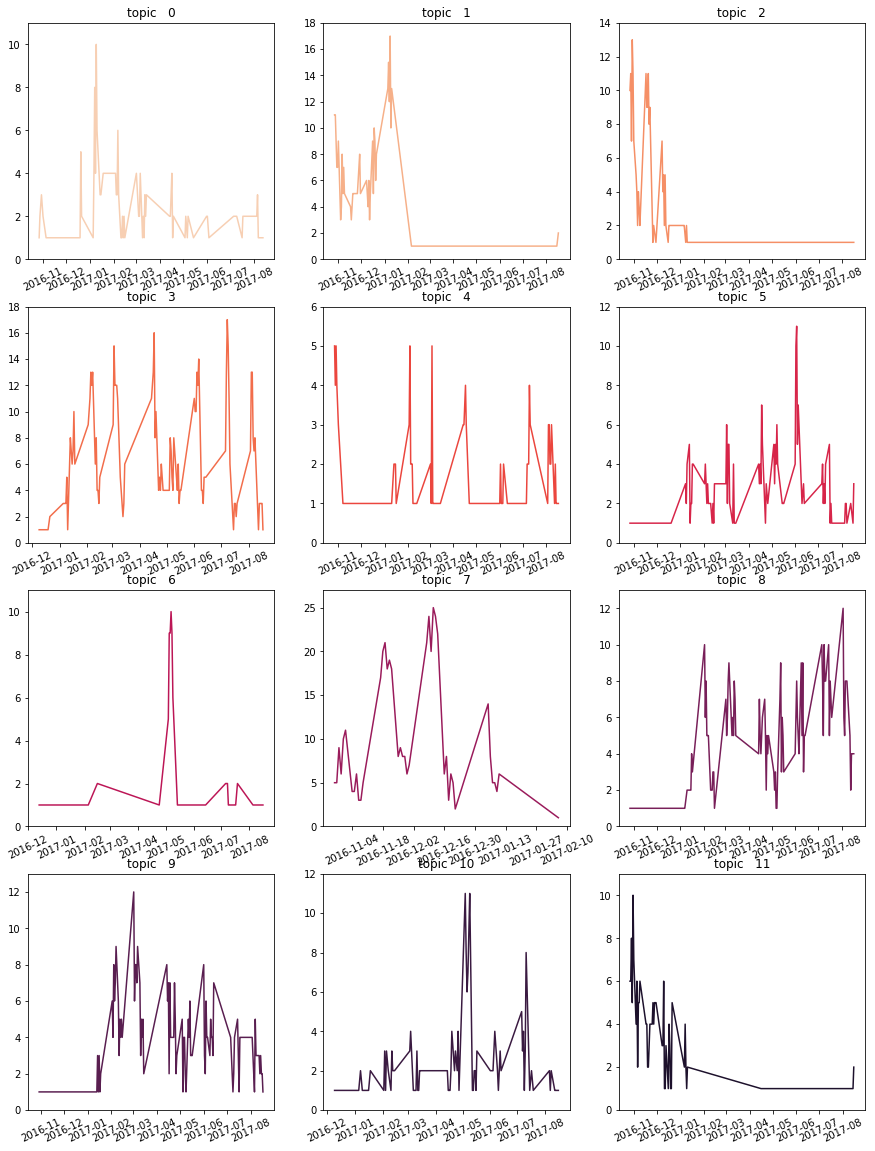

,day,documentID
0,2016-10-27,6
1,2016-10-28,6
2,2016-10-29,8


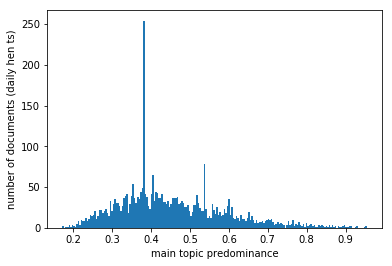


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [09:53<01:49, 54.74s/it]

Total running time: 0min

---- 0
0.092*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 0]" + 0.083*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 0]" + 0.052*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'small', 'small'], 0]" + 0.038*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'intermediate'], 0]" + 0.034*"[['zone_3', 'zone_4', 'zone_5'], ['small', 'small', 'large'], 0]" + 0.033*"[['zone_5', 'zone_4', 'zone_3'], ['large', 'intermediate', 'small'], 0]" + 0.033*"[['zone_4', 'zone_3', 'zone_4'], ['intermediate', 'small', 'intermediate'], 0]" + 0.029*"[['zone_4', 'zone_5', 'zone_4'], ['small', 'large', 'intermediate'], 0]" + 0.029*"[['zone_3', 'zone_4', 'zone_5'], ['small', 'intermediate', 'large'], 0]" + 0.026*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'intermediate', 'small'], 0]"

---- 1
0.064*"[['zone_2', 'zone_3', 'zone_4'], ['intermediate', 'small', 'intermediate'], 1]" + 0.054*"[['zone_3', 'zone_2', 'zone_3'], ['intermediate', 'intermed

topic,0,1,2,3,4,5,6,7,8,9,10,11,12
HenID,,,,,,,,,,,,,
hen_1,1.0,0.0,3.0,2.0,2.0,3.0,31.0,0.0,0.0,4.0,2.0,9.0,7.0
hen_10,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.0
hen_11,0.0,0.0,5.0,0.0,5.0,0.0,34.0,0.0,0.0,6.0,2.0,1.0,2.0


topic,0,1,2,3,4,5,6,7,8,9,10,11,12
HenID,,,,,,,,,,,,,
hen_29,0.0,1.515152,0.000000,0.0,0.0,12.121212,45.454545,4.545455,3.030303,0.0,1.515152,28.787879,3.030303
hen_35,0.0,5.000000,1.666667,0.0,0.0,5.000000,60.000000,0.000000,0.000000,0.0,0.000000,23.333333,5.000000
hen_72,0.0,0.000000,0.000000,0.0,0.0,7.843137,49.019608,1.960784,0.000000,0.0,3.921569,35.294118,1.960784


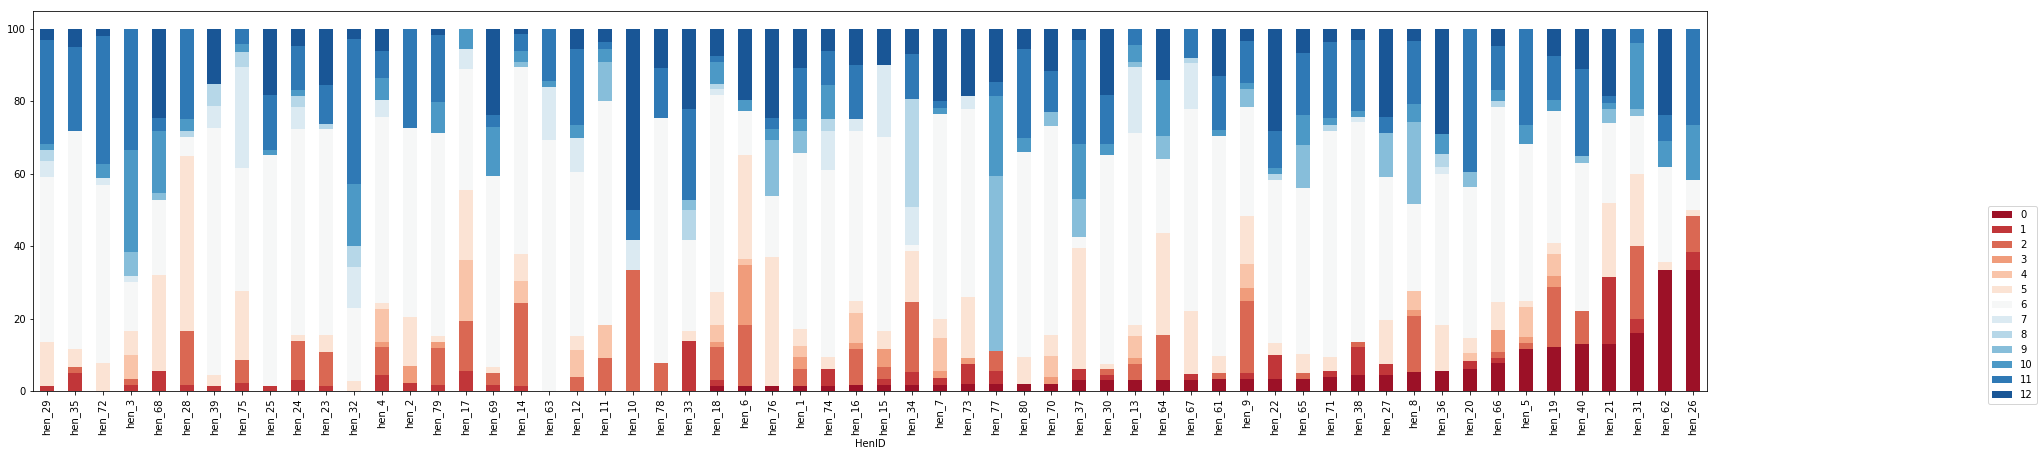

64
48
35
18
12
95
107
43
37
64
82
42
55


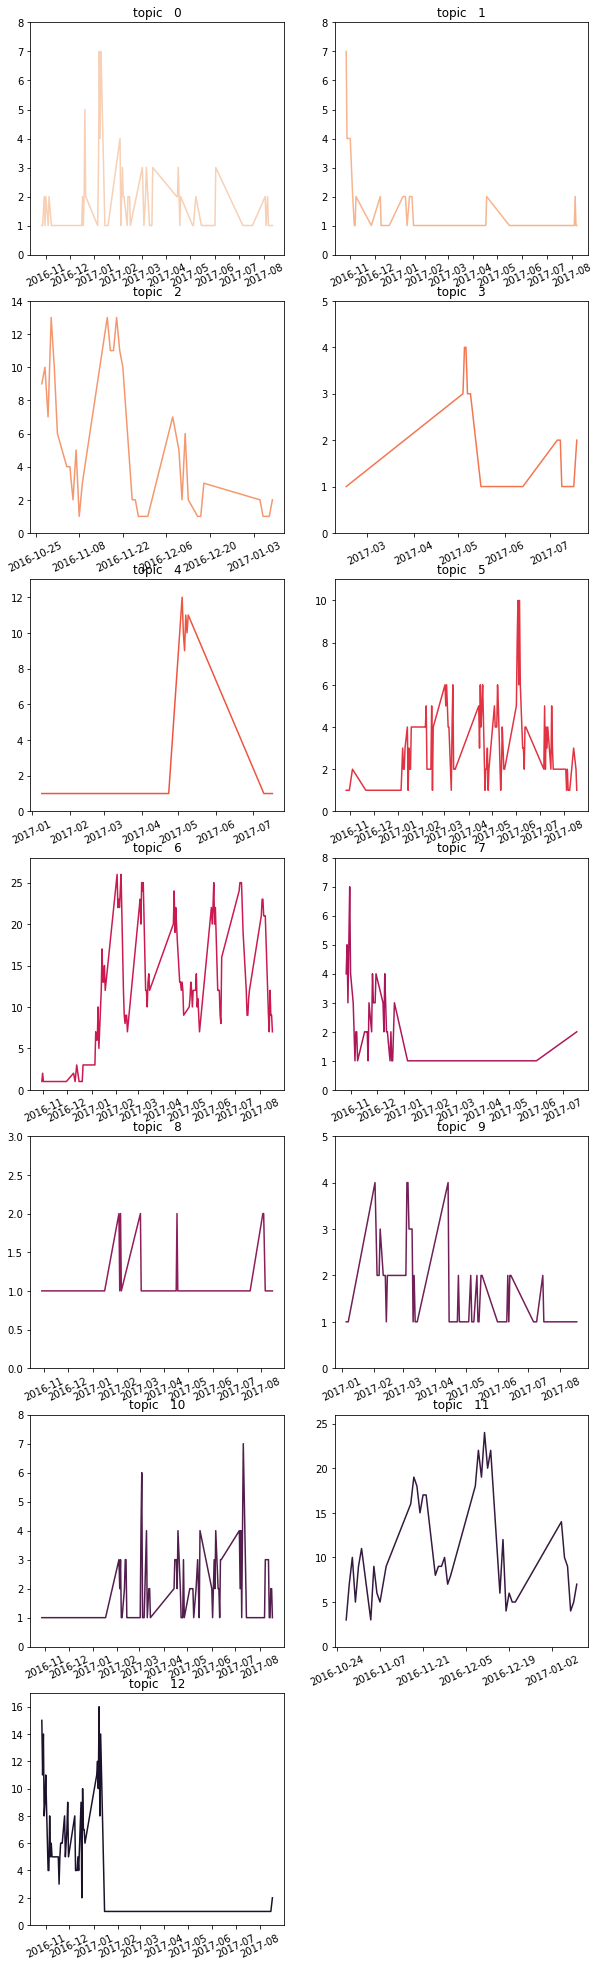

,day,documentID
0,2016-10-27,15
1,2016-10-28,11
2,2016-10-29,14


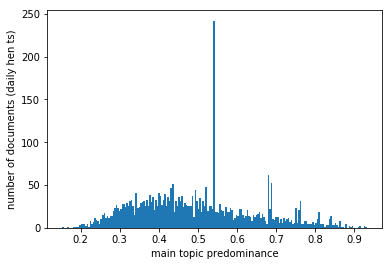


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [10:50<00:55, 55.36s/it]

Total running time: 0min

---- 0
0.108*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'large', 'intermediate'], 1]" + 0.103*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'large'], 1]" + 0.069*"[['zone_4', 'zone_5', 'zone_4'], ['large', 'large', 'intermediate'], 1]" + 0.065*"[['zone_5', 'zone_4', 'zone_5'], ['large', 'intermediate', 'intermediate'], 1]" + 0.063*"[['zone_5', 'zone_4', 'zone_5'], ['intermediate', 'large', 'large'], 1]" + 0.044*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'intermediate'], 1]" + 0.042*"[['zone_4', 'zone_5', 'zone_4'], ['intermediate', 'intermediate', 'large'], 1]" + 0.028*"[['zone_3', 'zone_4', 'zone_3'], ['small', 'small', 'small'], 0]" + 0.028*"[['zone_4', 'zone_3', 'zone_4'], ['small', 'small', 'small'], 0]" + 0.024*"[['zone_5', 'zone_4', 'zone_5'], ['intermediate', 'intermediate', 'intermediate'], 1]"

---- 1
0.085*"[['zone_2', 'zone_3', 'zone_4'], ['intermediate', 'small', 'intermediate'], 1]" + 0.062*"[['zone_3'

topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13
HenID,,,,,,,,,,,,,,
hen_1,28.0,0.0,1.0,2.0,11.0,2.0,8.0,0.0,3.0,3.0,3.0,1.0,2.0,0.0
hen_10,0.0,1.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0
hen_11,27.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,3.0,5.0,7.0,2.0,2.0,0.0


topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13
HenID,,,,,,,,,,,,,,
hen_10,0.0,8.333333,25.000000,0.0,8.333333,0.00000,8.333333,8.333333,0.000000,0.000000,0.000000,41.666667,0.0,0.0
hen_77,0.0,1.851852,3.703704,0.0,1.851852,0.00000,22.222222,0.000000,0.000000,61.111111,9.259259,0.000000,0.0,0.0
hen_34,0.0,21.052632,19.298246,0.0,12.280702,17.54386,3.508772,22.807018,1.754386,0.000000,0.000000,1.754386,0.0,0.0


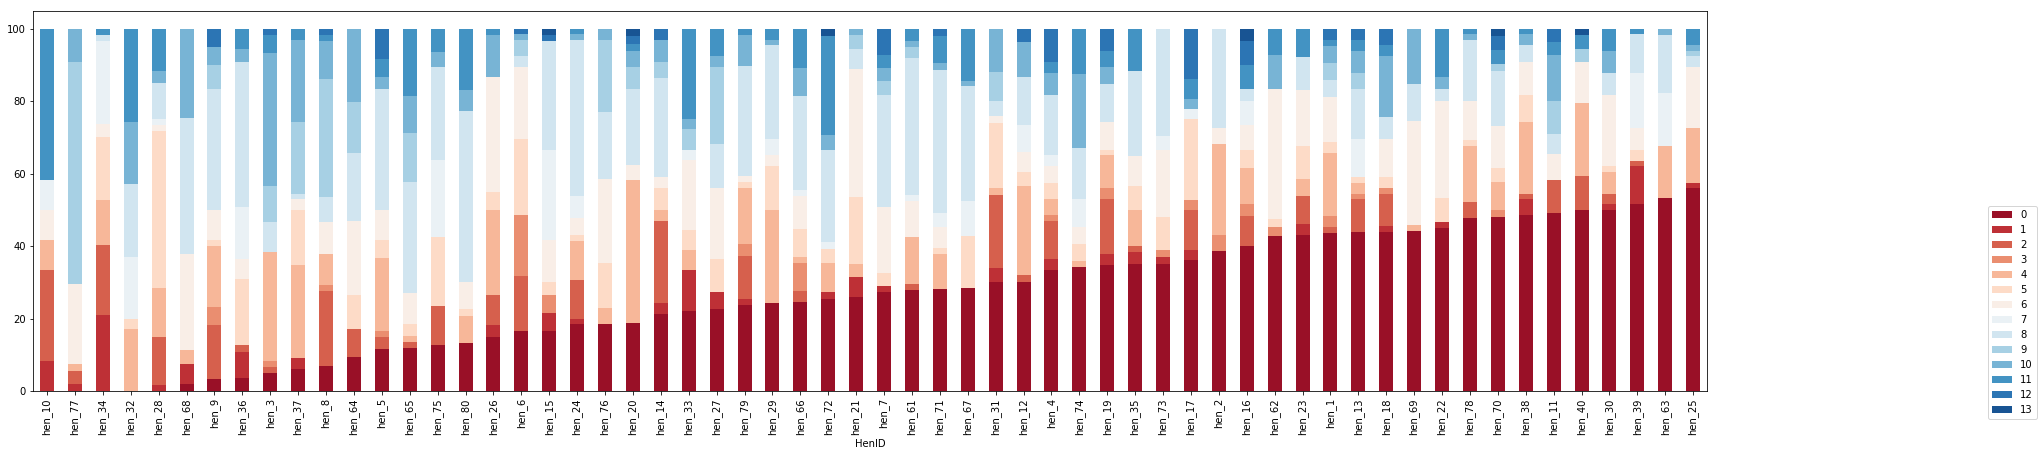

113
40
34
20
41
83
66
58
94
71
88
41
10
6


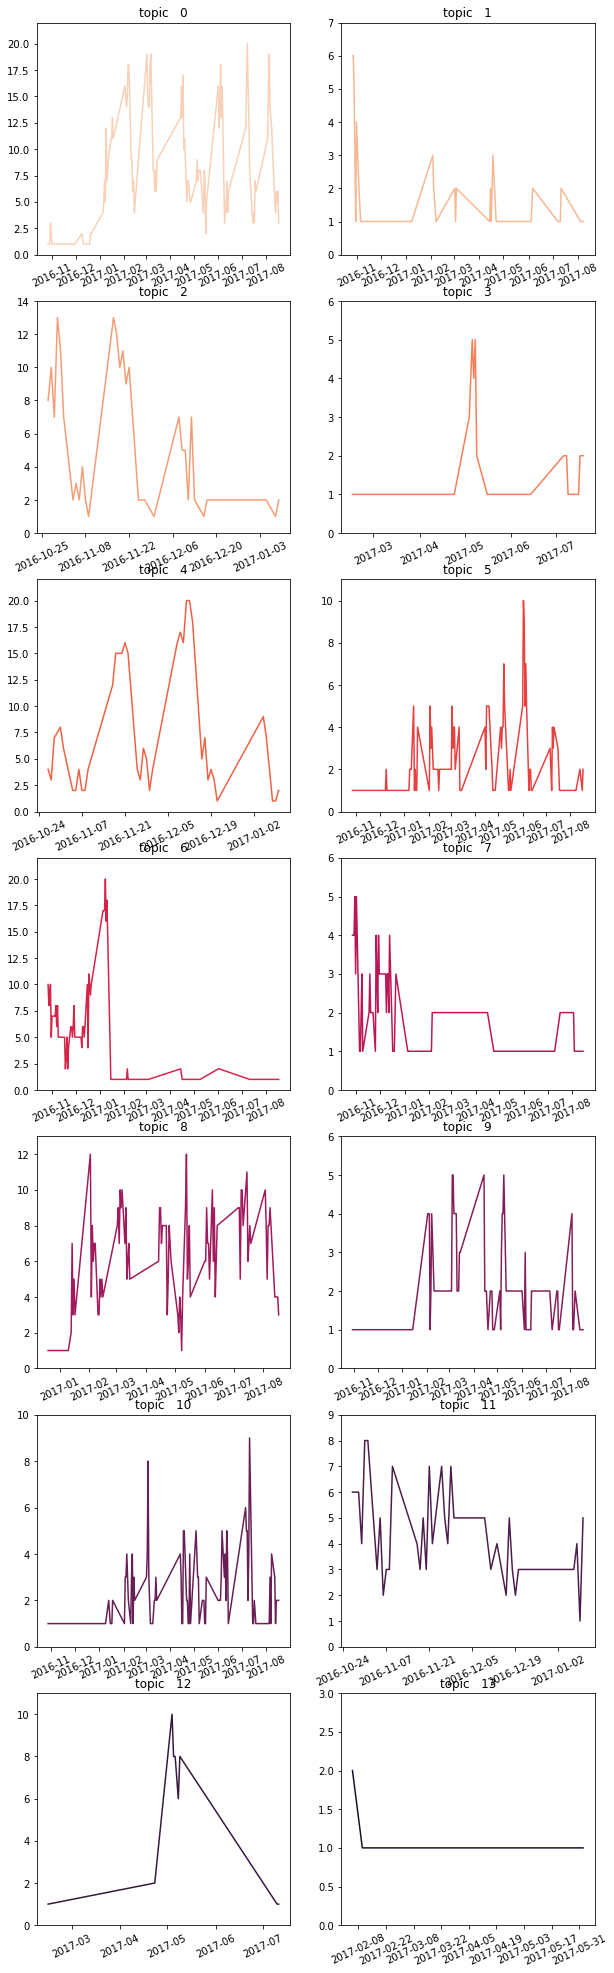

,day,documentID
0,2017-02-05,2
1,2017-02-10,1
2,2017-04-18,1


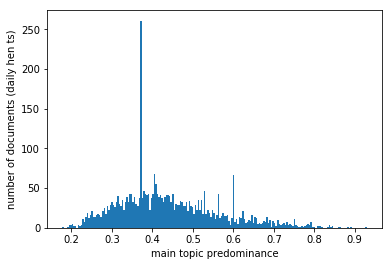


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [11:46<00:00, 55.61s/it]


In [9]:
for nbr_topics in tqdm.tqdm(range(2,15)): 

    #create a director if not existing
    path_save = os.path.join(path_extracted_data,'visual','LDA', title_, str(nbr_topics))
    if not os.path.exists(path_save):
        os.makedirs(path_save)
        
    #train lda
    start = time.time()
    lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                   num_topics=nbr_topics, 
                                   passes=30, 
                                   chunksize=50, 
                                   random_state=100,
                                   update_every=5, 
                                   alpha='auto', 
                                   per_word_topics=False)
    lda.save(os.path.join(path_save,'model'+str(nbr_topics)+'.gensim'))
    end = time.time()
    print ("Total running time: %dmin"%((end-start)/60))

    #show the latent topics
    for topicsID_topicsWordDistribution in lda.print_topics():
        print('\n----',topicsID_topicsWordDistribution[0])
        print(topicsID_topicsWordDistribution[1])
        
    #summarize the results
    df_topics = pd.DataFrame(list(documents.items()),columns=['documentID','li_words'])
    df_topics['li_words_cleaned'] = df_topics['documentID'].map(lambda x: cleaned_documents[x])
    df_topics['corpus'] = df_topics['li_words_cleaned'].map(lambda x: dictionary.doc2bow(x))
    df_topics['lda_corpus'] = df_topics['corpus'].map(lambda x: lda[x])

    #add info on hen
    df_topics['HenID'] = df_topics['documentID'].map(lambda x: x.split('/-/')[0])
    df_topics['day'] = df_topics['documentID'].map(lambda x: dt.datetime.strptime(x.split('/-/')[1], '%Y-%m-%d'))

    #add info of topic 
    df_topics['topic_info'] = df_topics['lda_corpus'].map(lambda x: sorted(x,key=itemgetter(1))[-1])
    df_topics['topic'] = df_topics['topic_info'].map(lambda x: x[0])
    df_topics['topic_proba'] = df_topics['topic_info'].map(lambda x: x[1])
    for t in range(nbr_topics):
        df_topics['topic_'+str(t)+'_proba'] = df_topics['lda_corpus'].map(lambda x: max([i[1] for i in x if i[0]==t]+[0]))

    #save
    df_topics.to_csv(os.path.join(path_save,'df_topics'+str(nbr_topics)+'.csv'), index=False,sep=';')
    print(df_topics.shape)
    df_topics.head(3)
    print(df_topics['topic'].value_counts())
    
    ### topics repartition across hens
    df_plot = df_topics.groupby(['HenID','topic']).size().reset_index().pivot(columns='topic', index='HenID', values=0)
    df_plot = df_plot.fillna(0)
    display(df_plot.head(3))
    df_plot_normalized = df_plot.div(df_plot.sum(axis=1)*0.01, axis=0).sort_values([0]) #sort accoridng to subject 0
    display(df_plot_normalized.head(3))
    li_color = sns.color_palette("RdBu", nbr_topics)
    df_plot_normalized.plot(x=df_plot_normalized.index, kind='bar', stacked=True, figsize=(30,7), 
                            legend=True, color=li_color).legend(bbox_to_anchor=(1.2, 0.5));
    plt.savefig(os.path.join(path_save,'topic_repartition_across_hen_'+str(nbr_topics)+'.png'), 
                dpi=300, format='png', bbox_inches='tight')
    plt.show()
    
    ### topic mixture across documents    
    if all_:
        for t in range(nbr_topics):
            df_plot_normalized = df_topics[['topic_'+str(i)+'_proba' for i in range(nbr_topics)]].sort_values(['topic_'+str(t)+'_proba'])
            df_plot_normalized.plot(x=df_plot_normalized.index, kind='bar', stacked=True, figsize=(40,10), 
                                    legend=True).legend(bbox_to_anchor=(1.2, 0.5));
            plt.savefig(os.path.join(path_save, 'topic_mixture_across_document_'+str(t)+'.png'),dpi=300,format='png',bbox_inches='tight')
            plt.show()
        
    ### topics appearance across days
    df_plot = df_topics.sort_values('day', ascending=True).copy()
    #dico_topicID_color = {0:(0.979891, 0.90894778, 0.84827858), 1:'blue', 2:'yellow', 3:'green', 4:'grey', 5:'lime', 6:'orange'}
    li_color = sns.color_palette("rocket_r", nbr_topics)
    c = 2
    if nbr_topics%3==0:
        c = 3
    l = math.ceil(nbr_topics/c)
    fig = plt.figure(figsize=(c*5, l*5))
    x = df_plot['day'].unique()
    for i, (t, df_) in enumerate(df_plot.groupby(['topic'])):
        ax = plt.subplot(l,c,i+1)
        df_ = df_.groupby(['day'])['documentID'].count().reset_index()
        x = df_['day'].tolist()
        y = df_['documentID'].tolist()
        print(len(x))
        plt.plot(x,y,color=li_color[i])
        plt.ylim(0,max(y)+max(int(max(y)*0.1),1))
        for label in ax.get_xticklabels():
            label.set_rotation(25) 
        plt.title('topic   '+str(t))
    plt.savefig(os.path.join(path_save,'topic_appearance_across_days_.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()
    display(df_.head(3))    
    
    ### hens main topics across days
    if all_:
        df_plot = df_topics.sort_values('day', ascending=True).copy()
        #x = list(set(df_plot['day'].tolist()))
        for t in range(nbr_topics):
            fig = plt.figure(figsize=(20,6))
            for i, (h, df_) in enumerate(df_plot.groupby(['HenID'])):
                x = df_['day'].tolist()
                y = df_['topic_'+str(t)+'_proba'].tolist()
                plt.plot(x,y)
                plt.show()
                fig = plt.figure(figsize=(20,6))
                if i==5:
                    sys.exit()
            plt.title('topic   '+str(t))
            plt.show()
        
    ### main topics proba
    plt.hist(df_topics['topic_proba'].dropna(), bins=200)
    plt.xlabel('main topic predominance')
    plt.ylabel('number of documents (daily hen ts)');
    plt.savefig(os.path.join(path_save,'main_topic_proba.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()
    
    ### plot visual time series into cluster-folders
    for i in range(0,nbr_topics):
        path_ts = os.path.join(path_save, 'timeseries_plot_cluster', str(i))
        if not os.path.exists(path_ts):
            os.makedirs(path_ts)

    path_ = r'D:\vm_exchange\AVIFORUM\data\extracted_info_mobility_VF\visual\TimeSeriesPlot\time_series_plot'

    for i in tqdm.tqdm(range(df_topics.shape[0])):
        HenID = df_topics.iloc[i]['HenID']
        day = df_topics.iloc[i]['day']
        topic = df_topics.iloc[i]['topic']
        image_name = 'VF_'+str(day).split(' ')[0]+'_'+HenID+'.png'
        shutil.copy(os.path.join(path_, image_name), 
                    os.path.join(path_save, 'timeseries_plot_cluster', str(topic), image_name))
        
    #LDA nice visual
    lda_model = gensim.models.ldamodel.LdaModel.load(os.path.join(path_save, 'model'+str(nbr_topics)+'.gensim'))
    lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)
    pyLDAvis.save_html(lda_display, os.path.join(path_save, str(nbr_topics)+'_lda.html'))

In [10]:
#df_summary = df_topics.groupby(['topic'])['HenID','day'].agg(lambda x: Counter(x)).reset_index()

# TODO